<a href="https://colab.research.google.com/github/vaas-umputer/edge-cloud-workflow-scheduler/blob/main/enhancing_50percent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torch_geometric stable-baselines3 gym numpy shimmy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18

In [2]:
import json
import networkx as nx
from rich.console import Console
from rich.table import Table

def print_dag_features(dag_files=["balanced_cybershake_dag.json", "balanced_montage_dag.json"]):
    console = Console()
    feature_keys = [
        "execution_time", "cpu_usage", "memory_usage", "arrival_time",
        "power_usage", "monetary_cost", "energy_cost"
    ]

    for dag_file in dag_files:
        try:
            with open(dag_file, "r") as f:
                dag_json = json.load(f)
            dag = nx.node_link_graph(dag_json, edges="links")

            tasks = []
            for node in dag.nodes():
                node_data = dag.nodes[node]
                task_features = {
                    key: float(node_data.get(key, 1.0 if key == "execution_time" else 0.0))
                    for key in feature_keys
                }
                total_comm = sum(
                    dag.edges.get((node, succ), {}).get("T_comm", 0.1)
                    for succ in dag.successors(node)
                )
                tasks.append({
                    "task_id": str(node),
                    **task_features,
                    "total_comm": total_comm
                })

            table = Table(title=f"DAG Features ({dag_file.split('_')[1].split('.')[0].capitalize()})")
            table.add_column("Task ID", justify="center")
            for key in feature_keys:
                table.add_column(key.replace("_", " ").title(), justify="center")
            table.add_column("Total Comm Time (s)", justify="center")

            for task in tasks:
                table.add_row(
                    task["task_id"],
                    *[f"{task[key]:.2f}" for key in feature_keys],
                    f"{task['total_comm']:.2f}"
                )

            console.print(table)
            console.log(f"Displayed {len(tasks)} tasks from {dag_file}")

        except Exception as e:
            console.log(f"Error processing {dag_file}: {e}")

if __name__ == "__main__":
    print_dag_features()

                                             DAG Features (Cybershake)                                             
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃         ┃ Execution  ┃           ┃   Memory   ┃  Arrival   ┃   Power    ┃  Monetary  ┃             ┃ Total Comm ┃
┃ Task ID ┃    Time    ┃ Cpu Usage ┃   Usage    ┃    Time    ┃   Usage    ┃    Cost    ┃ Energy Cost ┃  Time (s)  ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ ID00237 │    1.00    │   0.56    │    0.01    │    5.48    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00344 │   63.17    │   0.04    │    0.03    │   18.93    │   112.00   │    9.48    │    0.00     │    0.00    │
│ ID00371 │    2.00    │   0.39    │    0.01    │    9.47    │   217.00   │    0.30    │    0.00     │    0.00    │
│ ID00388 │   59.00    │   0.06    │    0.02    │   13.91    │   117.40   │    8.85    │    0.00     │    0.00    │
│ ID00378 │   62.00    │   0.02    │    0.03    │    6.86    │   106.00   │    9.30    │    0.00     │    0.00    │
│ ID00732 │    1.00    │   0.56    │    0.01    │    0.44    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00275 │    1.00    │   0.56    │    0.01    │   18.33    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00366 │   28.67    │   0.91    │    0.01    │    1.18    │   374.03   │    4.30    │    0.00     │    0.18    │
│ ID00079 │   59.00    │   0.06    │    0.02    │    1.38    │   117.40   │    8.85    │    0.00     │    0.00    │
│ ID00495 │   28.67    │   0.91    │    0.01    │    0.60    │   374.03   │    4.30    │    0.00     │    0.00    │
│ ID00557 │   44.00    │   0.94    │    0.01    │   11.73    │   382.00   │    6.60    │    0.00     │    0.01    │
│ ID00345 │    1.00    │   0.56    │    0.01    │   11.04    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00600 │    1.00    │   0.56    │    0.01    │    7.56    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00569 │   44.64    │   0.92    │    0.01    │    2.56    │   375.00   │    6.70    │    0.00     │    0.02    │
│ ID00146 │    1.00    │   0.56    │    0.01    │    1.62    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00832 │   45.89    │   0.89    │    0.01    │    4.94    │   366.00   │    6.88    │    0.00     │    0.00    │
│ ID00880 │   48.67    │   0.99    │    0.01    │    5.89    │   396.00   │    7.30    │    0.00     │    0.00    │
│ ID00618 │    2.00    │   0.39    │    0.01    │   54.13    │   217.00   │    0.30    │    0.00     │    0.00    │
│ ID00006 │    1.00    │   0.56    │    0.01    │   17.37    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00516 │    1.00    │   0.56    │    0.01    │    0.81    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00315 │    1.00    │   0.56    │    0.01    │    4.07    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00892 │   44.00    │   0.94    │    0.01    │    3.81    │   382.00   │    6.60    │    0.00     │    0.00    │
│ ID00050 │    2.00    │   0.39    │    0.01    │   23.65    │   217.00   │    0.30    │    0.00     │    0.00    │
│ ID00989 │    1.00    │   0.56    │    0.01    │    2.10    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00584 │    1.00    │   0.56    │    0.01    │    6.39    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00765 │    1.00    │   0.56    │    0.01    │   16.47    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00327 │    1.00    │   0.56    │    0.01    │   19.26    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00542 │    1.00    │   0.56    │    0.01    │    2.44    │   268.00   │    0.15    │    0.00     │    0.00    │
│ ID00390 │   30.44    │   0.61    │    0.02    │   28.33    │   283.89   │    4.57    │    0.00     │    0.00    │
│ ID00519 │   20.77    │   0.90    │    0.01    │    5.1

[18:28:38] Displayed 800 tasks from balanced_cybershake_dag.json                  <ipython-input-2-9d3216a5ec28>:50

                                              DAG Features (Montage)                                               
┏━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃         ┃ Execution  ┃           ┃   Memory   ┃  Arrival   ┃   Power    ┃  Monetary  ┃             ┃ Total Comm ┃
┃ Task ID ┃    Time    ┃ Cpu Usage ┃   Usage    ┃    Time    ┃   Usage    ┃    Cost    ┃ Energy Cost ┃  Time (s)  ┃
┡━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ ID00759 │   10.65    │   0.74    │    0.01    │    4.87    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00421 │   10.65    │   0.74    │    0.01    │   10.31    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00482 │   10.65    │   0.74    │    0.01    │    5.22    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00142 │   13.00    │   0.65    │    0.01    │   22.15    │   293.50   │    1.95    │    0.00     │    1.15    │
│ ID00664 │   10.65    │   0.74    │    0.01    │    5.90    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00518 │   10.65    │   0.74    │    0.01    │   12.12    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00822 │   10.65    │   0.74    │    0.01    │    1.77    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00768 │   10.65    │   0.74    │    0.01    │    6.72    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00134 │   13.50    │   0.65    │    0.01    │    7.40    │   293.50   │    2.02    │    0.00     │    0.18    │
│ ID00583 │   10.65    │   0.74    │    0.01    │   11.35    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00149 │   13.50    │   0.65    │    0.01    │    0.42    │   293.50   │    2.02    │    0.00     │    0.47    │
│ ID00106 │   13.50    │   0.65    │    0.01    │    0.10    │   293.50   │    2.02    │    0.00     │    0.59    │
│ ID00089 │   13.50    │   0.65    │    0.01    │   15.83    │   293.50   │    2.02    │    0.00     │    0.34    │
│ ID00271 │   10.65    │   0.74    │    0.01    │    9.20    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00884 │   11.00    │   0.21    │    0.01    │    2.68    │   161.50   │    1.65    │    0.00     │    0.02    │
│ ID00483 │   10.65    │   0.74    │    0.01    │   22.55    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00409 │   10.65    │   0.74    │    0.01    │    4.47    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00077 │   13.50    │   0.65    │    0.01    │    7.96    │   293.50   │    2.02    │    0.00     │    0.26    │
│ ID00975 │   10.65    │   0.74    │    0.01    │    5.12    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00761 │   10.65    │   0.74    │    0.01    │    1.13    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00696 │   10.65    │   0.74    │    0.01    │    6.02    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00349 │   10.65    │   0.74    │    0.01    │    1.22    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00440 │   10.65    │   0.74    │    0.01    │   17.72    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00742 │   10.65    │   0.74    │    0.01    │    6.12    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00130 │   13.50    │   0.65    │    0.01    │   15.47    │   293.50   │    2.02    │    0.00     │    0.56    │
│ ID00263 │   10.65    │   0.74    │    0.01    │    8.98    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00316 │   10.65    │   0.74    │    0.01    │   21.20    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00293 │   10.65    │   0.74    │    0.01    │    1.36    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00548 │   10.65    │   0.74    │    0.01    │    0.21    │   321.82   │    1.60    │    0.00     │    0.00    │
│ ID00261 │   10.65    │   0.74    │    0.01    │    7.0

[18:28:41] Displayed 800 tasks from balanced_montage_dag.json                     <ipython-input-2-9d3216a5ec28>:50

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class ContrastiveGAT(nn.Module):
    def __init__(self, in_channels=9, hidden_channels=16, embedding_dim=32, heads=4):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.2, add_self_loops=False)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=0.2, add_self_loops=False)
        self.node_to_embed = nn.Linear(hidden_channels * heads, embedding_dim)
        self.edge_proj = nn.Linear(1, hidden_channels)
        self.graph_fc = nn.Linear(hidden_channels * heads, embedding_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        # Generate task and graph embeddings
        # Inputs: x [num_nodes, 9], edge_index [2, num_edges], edge_attr [num_edges, 1], batch [num_nodes]
        # Outputs: task_embeddings [num_nodes, 32], graph_embedding [num_graphs, 32]

        x = torch.nan_to_num(x, nan=0.0)
        edge_attr = edge_attr if edge_attr is not None else torch.full((edge_index.shape[1], 1), 0.1, device=x.device)
        edge_attr = torch.nan_to_num(edge_attr, nan=0.1)

        edge_attr = self.edge_proj(edge_attr)
        x = F.relu(self.gat1(x, edge_index, edge_attr=edge_attr))
        x = F.dropout(x, p=0.2, training=True)
        x = F.relu(self.gat2(x, edge_index, edge_attr=edge_attr))

        task_embeddings = self.node_to_embed(x)
        graph_embedding = global_mean_pool(x, batch)
        graph_embedding = self.graph_fc(graph_embedding)

        return task_embeddings, graph_embedding

    def contrastive_loss(self, embeddings, edge_index, num_nodes):
        # Contrastive loss for connected task embeddings
        embeddings = torch.nan_to_num(embeddings, nan=0.0)
        if edge_index.shape[1] == 0:
            return torch.tensor(0.0, device=embeddings.device, requires_grad=True)

        pos_pairs = embeddings[edge_index[0]] - embeddings[edge_index[1]]
        pos_loss = (pos_pairs ** 2).sum(dim=1).mean()

        num_neg = min(int(num_nodes * 0.1), 500)
        neg_idx1 = torch.randint(0, num_nodes, (num_neg,), device=embeddings.device)
        neg_idx2 = torch.randint(0, num_nodes, (num_neg,), device=embeddings.device)
        mask = neg_idx1 != neg_idx2
        neg_idx1, neg_idx2 = neg_idx1[mask], neg_idx2[mask]

        if len(neg_idx1) == 0:
            return pos_loss

        neg_pairs = embeddings[neg_idx1] - embeddings[neg_idx2]
        neg_loss = F.relu(1.0 - (neg_pairs ** 2).sum(dim=1)).mean()
        return pos_loss + 0.5 * neg_loss

In [49]:
import torch
from torch_geometric.data import Data
import json
import networkx as nx
import numpy as np
from rich.console import Console

class GNNTrainer:
    def __init__(self, dag_file, embeddings_file, model_file="gnn_model.pth", max_nodes=1000, embedding_dim=32):
        self.dag_file = dag_file
        self.embeddings_file = embeddings_file
        self.model_file = model_file
        self.max_nodes = max_nodes
        self.embedding_dim = embedding_dim
        self.console = Console()
        self.dag = self.load_dag()
        self.model = ContrastiveGAT(embedding_dim=self.embedding_dim)

    def load_dag(self):
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)
        dag = nx.node_link_graph(dag_json, edges="links")
        if len(dag.nodes) > self.max_nodes:
            dag = dag.subgraph(list(dag.nodes)[:self.max_nodes]).copy()
        return dag

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
        self.model.eval()

    def prepare_data(self):
        node_to_idx = {nid: i for i, nid in enumerate(self.dag.nodes)}
        feature_keys = ["execution_time", "cpu_usage", "memory_usage", "arrival_time", "power_usage", "monetary_cost", "energy_cost"]
        x = torch.tensor([
            [float(self.dag.nodes[n].get(k, 0.5)) for k in feature_keys] +
            ([1.0, 0.0] if self.dag.nodes[n].get("machine_type", "cloud") == "edge" else [0.0, 1.0])
            for n in self.dag.nodes
        ], dtype=torch.float)
        x = torch.nan_to_num(x, nan=0.5)
        x = (x - x.mean(dim=0)) / torch.where(x.std(dim=0) > 0, x.std(dim=0), torch.ones_like(x.std(dim=0)))
        edge_index = torch.tensor([[node_to_idx[e[0]], node_to_idx[e[1]]] for e in self.dag.edges], dtype=torch.long).t() if self.dag.edges else torch.tensor([[], []], dtype=torch.long)
        edge_attr = torch.tensor([[self.dag.edges[e].get("T_comm", 0.1)] for e in self.dag.edges], dtype=torch.float) if self.dag.edges else torch.tensor([[0.1]], dtype=torch.float)
        edge_attr = torch.nan_to_num(edge_attr, nan=0.1)
        batch = torch.zeros(len(self.dag.nodes), dtype=torch.long)
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)

    def get_mc_embeddings(self, model, data, num_samples=30):
        model.eval()
        task_embed_samples = [
            model(data.x, data.edge_index, data.edge_attr, data.batch)[0].unsqueeze(0)
            for _ in range(num_samples)
        ]
        task_embed_samples = torch.cat(task_embed_samples, dim=0)
        return task_embed_samples.mean(dim=0), task_embed_samples.var(dim=0)

    def compute_metrics(self, embeddings, edge_index, task_ids):
        embeddings = embeddings.detach().cpu().numpy()
        pos_sim = neg_sim = emb_var = 0.0
        if edge_index.shape[1] > 0:
            pos_sim = np.mean([
                np.dot(embeddings[i], embeddings[j]) / (max(np.linalg.norm(embeddings[i]), 1e-8) * max(np.linalg.norm(embeddings[j]), 1e-8))
                for i, j in zip(edge_index[0].numpy(), edge_index[1].numpy())
            ])
        n_samples = min(100, len(task_ids))
        idx1, idx2 = np.random.choice(len(task_ids), (2, n_samples), replace=True)
        mask = idx1 != idx2
        idx1, idx2 = idx1[mask], idx2[mask]
        if len(idx1) > 0:
            neg_sim = np.mean([
                np.dot(embeddings[i], embeddings[j]) / (max(np.linalg.norm(embeddings[i]), 1e-8) * max(np.linalg.norm(embeddings[j]), 1e-8))
                for i, j in zip(idx1, idx2)
            ])
        emb_var = np.var(embeddings, axis=0).mean() if embeddings.size > 0 else 0.0
        return {"pos_sim": pos_sim, "neg_sim": neg_sim, "emb_var": emb_var}

    def save_embeddings(self, data, device):
        self.model.eval()
        data = data.to(device)
        task_mean, task_var = self.get_mc_embeddings(self.model, data)
        task_embeddings_dict = {
            nid: {"mean": mean.tolist(), "uncertainty": var.tolist()}
            for nid, mean, var in zip(self.dag.nodes, task_mean, task_var)
        }
        torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
        self.console.log(f"Saved embeddings to {self.embeddings_file}")

    def train(self, epochs=10):
        self.console.log(f"Training GNN with embedding_dim={self.embedding_dim}...")
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.console.log(f"Using device: {device}")
        self.model.to(device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        data = self.prepare_data().to(device)

        for epoch in range(1, epochs + 1):
            self.model.train()
            optimizer.zero_grad()
            task_embeddings, _ = self.model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = self.model.contrastive_loss(task_embeddings, data.edge_index, len(data.x))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()
            if epoch % 2 == 0:
                metrics = self.compute_metrics(task_embeddings, data.edge_index, list(self.dag.nodes))
                self.console.log(
                    f"Epoch {epoch}/{epochs}: Loss={loss.item():.4f}, "
                    f"Pos Sim={metrics['pos_sim']:.4f}, Neg Sim={metrics['neg_sim']:.4f}, "
                    f"Emb Var={metrics['emb_var']:.4f}"
                )

        self.model.eval()
        task_mean, task_var = self.get_mc_embeddings(self.model, data)
        task_embeddings_dict = {
            nid: {"mean": mean.tolist(), "uncertainty": var.tolist()}
            for nid, mean, var in zip(self.dag.nodes, task_mean, task_var)
        }
        torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
        torch.save(self.model.state_dict(), self.model_file)
        self.console.log(f"Saved embeddings to {self.embeddings_file}")
        self.console.log(f"Saved GNN model to {self.model_file}")
        metrics = self.compute_metrics(task_mean, data.edge_index, list(self.dag.nodes))
        self.console.log(
            f"Final Metrics: Pos Sim={metrics['pos_sim']:.4f}, Neg Sim={metrics['neg_sim']:.4f}, "
            f"Emb Var={metrics['emb_var']:.4f}"
        )

In [50]:
import torch
import numpy as np
from rich.console import Console

class TaskQueue:
    def __init__(self, dag, embeddings, task_ids, num_servers=5):
        self.dag = dag
        self.task_ids = task_ids
        self.tasks = {
            node: {
                "embedding": embeddings[i] if i < len(embeddings) else np.zeros(embeddings.shape[1]),
                "dependencies": set(dag.predecessors(node)),
                "exec_time": dag.nodes[node].get("execution_time", 1.0),
                "arrival_time": dag.nodes[node].get("arrival_time", 0.0),
                "monetary_cost": dag.nodes[node].get("monetary_cost", 1.0),
                "energy_cost": dag.nodes[node].get("energy_cost", 1.0),
                "placement": None,
                "server": None,
                "history": []
            } for i, node in enumerate(task_ids)
        }
        self.completed = set()
        self.running = {}
        self.server_loads = {"cloud": np.zeros(num_servers), "edge": np.zeros(num_servers)}
        self.edge_battery = np.full(num_servers, 100.0)
        self.network_latency = 0.5
        self.current_time = 0.0
        self.total_cost = 0.0
        self.total_energy = 0.0
        self.console = Console()
        self.cloud_base_power = np.random.uniform(10, 15, num_servers)
        self.edge_base_power = np.random.uniform(2, 5, num_servers)
        self.load_history = {"cloud": [], "edge": []}
        self.placement_log = {}
        self.overload_feedback = {"cloud": False, "edge": False}

    def reset(self):
        self.completed.clear()
        self.running.clear()
        self.server_loads = {"cloud": np.zeros_like(self.server_loads["cloud"]), "edge": np.zeros_like(self.server_loads["edge"])}
        self.edge_battery.fill(100.0)
        self.network_latency = 0.5
        self.current_time = 0.0
        self.total_cost = 0.0
        self.total_energy = 0.0
        self.load_history = {"cloud": [], "edge": []}
        self.placement_log.clear()
        for task in self.tasks.values():
            task["placement"] = None
            task["server"] = None
            task["history"].clear()

    def update_conditions(self):
        self.network_latency = np.random.uniform(0.3, 0.7)
        self.server_loads["cloud"] += np.random.uniform(0, 0.2, len(self.server_loads["cloud"]))
        self.server_loads["edge"] += np.random.uniform(0, 0.1, len(self.server_loads["edge"]))
        self.server_loads["cloud"] = np.clip(self.server_loads["cloud"], 0, 2.0)
        self.server_loads["edge"] = np.clip(self.server_loads["edge"], 0, 1.5)
        self.edge_battery = np.clip(self.edge_battery + 0.5, 0, 100)
        self.load_history["cloud"].append(self.server_loads["cloud"].copy())
        self.load_history["edge"].append(self.server_loads["edge"].copy())
        if len(self.load_history["cloud"]) > 10:
            self.load_history["cloud"].pop(0)
            self.load_history["edge"].pop(0)
        self.overload_feedback["cloud"] = np.any(self.server_loads["cloud"] > 2.0)
        self.overload_feedback["edge"] = np.any(self.server_loads["edge"] > 1.5) or np.any(self.edge_battery < 20)

    def get_ready_tasks(self):
        return [
            tid for tid, t in self.tasks.items()
            if tid not in self.running
            and tid not in self.completed
            and t["arrival_time"] <= self.current_time
            and t["dependencies"].issubset(self.completed)
        ]

    def update_running(self):
        completed = [t for t, info in self.running.items() if self.current_time >= info["expected_end"]]
        for task in completed:
            self.complete_task(task)
        self.edge_battery = np.minimum(self.edge_battery + 0.5, 100.0)
        if self.running and not completed:
            self.current_time += 0.5

    def clear_running(self):
        for task in list(self.running.keys()):
            self.complete_task(task)
        self.running.clear()
        self.current_time = max(self.current_time, 0.0)

    def start_task(self, task_id, placement, server, exec_time):
        if task_id not in self.tasks:
            return
        exec_time = min(exec_time, 10.0)
        base_power = self.cloud_base_power[server] if placement == "cloud" else self.edge_base_power[server]
        load_factor = min(self.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.4)
        energy = (base_power + load_factor * 5) * exec_time
        if placement == "edge":
            self.edge_battery[server] = max(0.0, self.edge_battery[server] - energy)
        self.server_loads[placement][server] += self.tasks[task_id]["exec_time"] / (3.0 if placement == "cloud" else 2.0)
        self.running[task_id] = {
            "placement": placement,
            "server": server,
            "expected_end": self.current_time + exec_time,
            "energy": energy,
            "exec_time": exec_time
        }
        self.placement_log[task_id] = {"placement": placement, "server": server}

    def complete_task(self, task_id):
        if task_id not in self.running:
            return
        task_info = self.running[task_id]
        exec_time = task_info["exec_time"]
        placement = task_info["placement"]
        server = task_info["server"]
        self.server_loads[placement][server] = max(0, self.server_loads[placement][server] - exec_time * 0.1)
        base_power = self.cloud_base_power[server] if placement == "cloud" else self.edge_base_power[server]
        load_factor = min(self.server_loads[placement][server] / (2.0 if placement == "cloud" else 1.5), 0.4)
        energy = (base_power + load_factor * 5) * exec_time
        cost = exec_time * (0.10 if placement == "cloud" else 0.05)
        sla_deadline = self.tasks[task_id]["exec_time"] * 1.5
        sla_met = 1 if exec_time <= sla_deadline else 0
        self.total_energy += energy
        self.total_cost += cost
        self.tasks[task_id]["history"].append({
            "exec_time": exec_time,
            "energy": energy,
            "cost": cost,
            "sla": sla_met,
            "placement": placement,
            "server": server,
            "timestamp": self.current_time
        })
        self.completed.add(task_id)
        del self.running[task_id]

    def get_historical_state(self, task_id):
        history = self.tasks[task_id]["history"]
        return np.array([1.0, 0.8, 0.5, 0.0, 1.0]) if not history else np.array([
            history[-1]["exec_time"],
            history[-1]["energy"],
            history[-1]["cost"],
            history[-1]["sla"],
            1 if history[-1]["placement"] == "cloud" else 0
        ])

    def predict_load(self, placement):
        history = self.load_history[placement]
        return np.mean(history, axis=0) if history else self.server_loads[placement]

In [92]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class Tier1SchedulerEnv(gym.Env):
    def __init__(self, task_queue, embeddings, task_ids, embeddings_var=None):
        super().__init__()
        self.task_queue = task_queue
        self.embeddings = embeddings
        self.task_ids = task_ids
        self.embeddings_var = embeddings_var
        self.action_space = spaces.MultiBinary(5)
        emb_dim = embeddings.shape[1]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=((emb_dim + 19 + 5) * 5,),
            dtype=np.float32
        )
        self.max_exec_time = 10.0

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.task_queue.reset()
        return self._get_obs(), {"reset": True}

    def _get_obs(self):
        ready_tasks = self.task_queue.get_ready_tasks()[:5]
        emb_dim = self.embeddings.shape[1]
        task_obs_dim = emb_dim + 19 + 5
        obs = []
        for i in range(5):
            if i < len(ready_tasks):
                tid = ready_tasks[i]
                idx = self.task_ids.index(tid) if tid in self.task_ids else -1
                emb = np.nan_to_num(self.embeddings[idx], nan=0.0) if idx >= 0 else np.zeros(emb_dim)
                system_state = np.concatenate([
                    [self.task_queue.current_time, len(self.task_queue.running), len(ready_tasks), self.task_queue.network_latency],
                    self.task_queue.server_loads["cloud"],
                    self.task_queue.server_loads["edge"],
                    self.task_queue.edge_battery
                ])
                historical_state = self.task_queue.get_historical_state(tid) if idx >= 0 else np.zeros(5)
                obs.append(np.concatenate([emb, system_state, historical_state]))
            else:
                obs.append(np.zeros(task_obs_dim))
        return np.concatenate(obs).astype(np.float32)

    def step(self, action):
        self.task_queue.update_running()
        ready_tasks = self.task_queue.get_ready_tasks()[:5]

        if not ready_tasks:
            self.task_queue.current_time += 0.5
            return self._get_obs(), 0, False, False, {"placements": {}}

        self.task_queue.update_conditions()
        placements = {}
        total_reward = 0

        for i, tid in enumerate(ready_tasks):
            if i >= len(action):
                break

            placement = "cloud" if action[i] == 0 else "edge"
            task = self.task_queue.tasks[tid]
            base_time = task["exec_time"]

            # --- Improved Reward Components ---
            # 1. Execution Time (penalize longer times)
            exec_time = base_time * (1 + 0.2 * np.mean(self.task_queue.server_loads[placement]))
            time_penalty = -0.2 * (exec_time / base_time)  # Normalized penalty

            # 2. SLA Compliance (higher weight)
            sla_met = 1 if exec_time <= base_time * 1.5 else 0
            sla_reward = 40.0 * sla_met  # Increased from 30

            # 3. Uncertainty Penalty (if embeddings_var available)
            uncertainty_penalty = 0
            if self.embeddings_var is not None and tid in self.task_ids:
                idx = self.task_ids.index(tid)
                if np.mean(self.embeddings_var[idx]) > 0.1 and placement == "edge":
                    uncertainty_penalty = -1.0  # Discourage edge placement for uncertain tasks

            # 4. Load Balancing Bonus
            load_bonus = 1.5 * (1 - np.mean(self.task_queue.server_loads[placement]))

            # Combined Reward
            reward = (
                sla_reward +
                time_penalty +
                load_bonus +
                uncertainty_penalty
            )
            total_reward += reward

            # Track placements
            placements[tid] = {
                "placement": placement,
                "exec_time": exec_time
            }

        terminated = len(self.task_queue.completed) == len(self.task_ids)
        return self._get_obs(), total_reward, terminated, False, {"placements": placements}

In [85]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces

class Tier2SchedulerEnv(gym.Env):
    def __init__(self, task_queue, embeddings, task_ids):
        super().__init__()
        self.task_queue = task_queue
        self.embeddings = embeddings
        self.task_ids = task_ids
        self.action_space = spaces.MultiDiscrete([5] * 5)
        emb_dim = embeddings.shape[1]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=((emb_dim + 19 + 5) * 5,),
            dtype=np.float32
        )
        self.current_tasks = []
        self.placements = {}
        self.max_exec_time = 10.0

    def reset(self, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self.current_tasks.clear()
        self.placements.clear()
        return self._get_obs(), {"reset": True}

    def _get_obs(self):
        task_obs_dim = self.embeddings.shape[1] + 19 + 5
        obs = []
        for i in range(5):
            if i < len(self.current_tasks):
                tid = self.current_tasks[i]
                idx = self.task_ids.index(tid) if tid in self.task_ids else -1
                emb = np.nan_to_num(self.embeddings[idx], nan=0.0) if idx >= 0 else np.zeros(self.embeddings.shape[1])
                system_state = np.concatenate([
                    [self.task_queue.current_time, len(self.task_queue.running), len(self.task_queue.get_ready_tasks()), self.task_queue.network_latency],
                    self.task_queue.server_loads["cloud"],
                    self.task_queue.server_loads["edge"],
                    self.task_queue.edge_battery if self.placements.get(tid) == "edge" else np.zeros(5)
                ])
                historical_state = self.task_queue.get_historical_state(tid) if idx >= 0 else np.zeros(5)
                obs.append(np.concatenate([emb, system_state, historical_state]))
            else:
                obs.append(np.zeros(task_obs_dim))
        return np.concatenate(obs).astype(np.float32)

    def step(self, action):
        total_reward = 0
        info_dict = {}
        edge_placements = sum(1 for tid in self.current_tasks if self.placements.get(tid) == "edge")
        cloud_placements = len(self.current_tasks) - edge_placements
        cloud_ratio = cloud_placements / len(self.current_tasks) if self.current_tasks else 0.0

        for i, tid in enumerate(self.current_tasks[:5]):
            server = int(action[i]) % 5
            placement = self.placements.get(tid, "cloud")
            base_time = min(self.task_queue.tasks[tid]["exec_time"], 5.0)
            exec_time = base_time
            if base_time > 3.0 and self.task_queue.server_loads["cloud"][server] < 1.5:
                placement = "cloud"
            if placement == "edge" and base_time > 5.0 and self.task_queue.edge_battery[server] < 20:
                exec_time = base_time / np.ceil(base_time / 2.0)
            predicted_load = self.task_queue.predict_load(placement)
            if predicted_load[server] >= (3.0 if placement == "cloud" else 2.0):
                total_reward -= 1
                continue
            load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)
            exec_time *= (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
            exec_time = min(exec_time, 5.0)
            self.task_queue.start_task(tid, placement, server, exec_time)
            sla_met = 1 if exec_time <= base_time * 1.5 else 0
            base_power = self.task_queue.cloud_base_power[server] if placement == "cloud" else self.task_queue.edge_base_power[server]
            energy = (base_power + load_factor * 5) * exec_time
            cost = exec_time * (0.10 if placement == "cloud" else 0.05)
            load_balance = -0.5 * np.std(self.task_queue.server_loads[placement])
            if cloud_ratio < 0.4:
                load_balance -= 0.7 * np.std(self.task_queue.server_loads["edge"])
                total_reward -= 5.0
            reward = 40.0 * sla_met - 0.05 * (exec_time / 5.0) - 0.02 * (energy / 5.0) - 0.03 * (cost / 10.0) + load_balance
            total_reward += reward
            info_dict[tid] = {"task": tid, "exec_time": exec_time, "energy": energy, "cost": cost, "placement": placement}

        self.task_queue.update_running()
        terminated = len(self.task_queue.completed) == len(self.task_ids)
        self.current_tasks.clear()
        self.placements.clear()
        return self._get_obs(), total_reward, terminated, False, {"tasks": info_dict, "cloud_ratio": cloud_ratio}

In [93]:
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from rich.console import Console
import json
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from rich.table import Table

class WorkflowScheduler:
    def __init__(self, dag_file, embeddings_file, validation_dag_file="balanced_montage_dag.json", max_nodes=1000):
        self.dag_file = dag_file
        self.embeddings_file = embeddings_file
        self.validation_dag_file = validation_dag_file
        self.max_nodes = max_nodes
        self.console = Console()
        self.dag, self.embeddings, self.task_ids, self.embeddings_var = self.load_dag_and_embeddings(
            self.dag_file, self.embeddings_file
        )
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)
        self.tier1_env = Tier1SchedulerEnv(self.task_queue, self.embeddings, self.task_ids, self.embeddings_var)
        self.tier2_env = Tier2SchedulerEnv(self.task_queue, self.embeddings, self.task_ids)
        self.tier1_model = None
        self.tier2_model = None
        self.metrics = {"hrl": None, "cloud": None, "edge": None}

    def load_dag_and_embeddings(self, dag_file, embeddings_file, is_validation=False):
        with open(dag_file, "r") as f:
            dag = nx.node_link_graph(json.load(f), edges="links")
        if len(dag.nodes) > self.max_nodes:
            dag = dag.subgraph(list(dag.nodes)[:self.max_nodes]).copy()

        if not os.path.exists(embeddings_file):
            trainer = GNNTrainer(dag_file, embeddings_file, embedding_dim=32)
            trainer.dag = dag
            if is_validation:
                trainer.load_model("gnn_model.pth")
                data = trainer.prepare_data()
                device = "cuda" if torch.cuda.is_available() else "cpu"
                trainer.save_embeddings(data, device)
            else:
                task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}
                torch.save({"task_embeddings": task_embeddings_dict}, embeddings_file)

        embeddings_data = torch.load(embeddings_file, map_location=torch.device('cpu'))
        task_embeddings_dict = embeddings_data["task_embeddings"]
        task_ids = list(dag.nodes())
        task_embeddings = np.array([task_embeddings_dict[tid]["mean"] for tid in task_ids])
        task_embeddings_var = np.array([task_embeddings_dict[tid]["uncertainty"] for tid in task_ids])
        embeddings_var = task_embeddings_var if np.any(task_embeddings_var) else None
        if embeddings_var is None:
            self.console.log(f"Warning: No variance data in embeddings for {dag_file}, uncertainty penalty disabled")
        return dag, task_embeddings, task_ids, embeddings_var

    def print_comparative_metrics(self):
        if not all(self.metrics.values()):
            self.console.log("Error: Not all metrics are available")
            return
        table = Table(title="Validation Metrics (Training: CyberShake, Validation: Montage)")
        headers = ["Metric", "HRL", "Cloud-Only", "Edge-Only"]
        for h in headers:
            table.add_column(h, justify="center")
        metrics_to_display = [
            ("DAG Used", "Montage", "Montage", "Montage"),
            ("Makespan (s)", "makespan", "{:.2f}"),
            ("Avg Exec Time (s)", "avg_exec_time", "{:.2f}"),
            ("Avg Energy (units)", "avg_energy", "{:.2f}"),
            ("Avg Cost ($)", "avg_cost", "{:.2f}"),
            ("SLA Compliance (%)", "sla_rate", "{:.2%}"),
            ("Cloud Ratio (%)", "cloud_ratio", "{:.2%}"),
            ("Throughput (tasks/s)", "throughput", "{:.2f}"),
            ("Avg Queue Length", "avg_queue_length", "{:.2f}"),
            ("Cloud Load Balance (std)", "cloud_load_balance", "{:.2f}"),
            ("Edge Load Balance (std)", "edge_load_balance", "{:.2f}"),
            ("Avg Edge Battery (%)", "avg_edge_battery", "{:.2f}"),
            ("Avg Reward", "avg_reward", "{:.2f}"),
            ("Tasks Completed", "completed_count", "{}/{}")
        ]
        for label, *args in metrics_to_display:
            row = [label]
            if len(args) == 3:  # Static values (e.g., DAG Used)
                row.extend(args)
            else:  # Dynamic metrics
                key, fmt = args
                for mode in ["hrl", "cloud", "edge"]:
                    metric = self.metrics[mode]
                    value = fmt.format(metric[key], metric["total_tasks"]) if key == "completed_count" else fmt.format(metric[key])
                    row.append(value)
            table.add_row(*row)
        self.console.print(table)

    def train_tier1(self, timesteps=20000):
      self.console.log("[Phase 1] Training Tier1 Scheduler...")
      self.tier1_env.task_queue.active_phase = True

      # Use PPO with better hyperparameters
      self.tier1_model = PPO(
          "MlpPolicy",
          DummyVecEnv([lambda: self.tier1_env]),
          n_steps=1024,          # Longer trajectories
          batch_size=64,         # Larger batches
          ent_coef=0.02,         # Slightly higher exploration
          verbose=0
      )

      self.tier1_model.learn(total_timesteps=timesteps)
      self.tier1_model.save("tier1_scheduler_new")
      self.tier1_env.task_queue.clear_running()

    def train_tier2(self, timesteps=20000):
        self.console.log("Training Tier 2...")
        self.tier1_env.reset()
        self.tier2_env.reset()
        self.tier1_env.task_queue.clear_running()
        self.tier2_env.task_queue.clear_running()
        self.tier1_env.task_queue.active_phase = True
        self.tier2_env.task_queue.active_phase = True
        try:
            self.tier1_model = PPO.load("tier1_scheduler_new")
        except FileNotFoundError:
            self.train_tier1(timesteps=5000)
        self.tier2_model = PPO("MlpPolicy", DummyVecEnv([lambda: self.tier2_env]), verbose=0, n_steps=256, ent_coef=0.05)
        obs = self.tier1_env.reset()[0]
        total_steps = timesteps // 128
        steps_taken = 0
        while steps_taken < total_steps and len(self.tier1_env.task_queue.completed) < len(self.task_ids):
            ready_tasks = self.tier1_env.task_queue.get_ready_tasks()
            if not ready_tasks and not self.tier1_env.task_queue.running:
                future_arrivals = [
                    t["arrival_time"] for t in self.tier1_env.task_queue.tasks.values()
                    if t["arrival_time"] > self.tier1_env.task_queue.current_time and t["dependencies"].issubset(self.tier1_env.task_queue.completed)
                ]
                if future_arrivals:
                    self.tier1_env.task_queue.current_time = self.tier2_env.task_queue.current_time = min(future_arrivals)
                    continue
                break
            action = self.tier1_model.predict(obs, deterministic=False)[0]
            obs, reward, _, _, info = self.tier1_env.step(action)
            if info["placements"]:
                self.tier2_env.current_tasks = list(info["placements"].keys())
                self.tier2_env.placements = {tid: info["placements"][tid]["placement"] for tid in info["placements"]}
                tier2_obs = self.tier2_env._get_obs()
                tier2_action = self.tier2_model.predict(tier2_obs, deterministic=False)[0]
                tier2_obs, reward2, done, _, tier2_info = self.tier2_env.step(tier2_action)
                if tier2_info["tasks"]:
                    self.tier2_model.learn(total_timesteps=128, reset_num_timesteps=False)
                    steps_taken += 1
            self.tier1_env.task_queue.update_running()
            self.tier2_env.task_queue.update_running()
            obs = self.tier1_env._get_obs()
        self.tier2_model.save("tier2_scheduler_new")
        self.tier1_env.task_queue.active_phase = False
        self.tier2_env.task_queue.active_phase = False
        self.console.log("Tier 2 training complete")

    def validate(self, baseline=False, mode="hrl"):
        validation_embeddings_file = "montage_embeddings.pth"
        validation_dag, validation_embeddings, validation_task_ids, validation_embeddings_var = self.load_dag_and_embeddings(
            self.validation_dag_file, validation_embeddings_file, is_validation=True
        )
        self.task_queue = TaskQueue(validation_dag, validation_embeddings, validation_task_ids)
        self.tier1_env = Tier1SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids, validation_embeddings_var)
        self.tier2_env = Tier2SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids)
        self.task_queue.reset()
        self.tier1_env.reset()
        self.tier2_env.reset()
        if mode == "hrl":
            try:
                self.tier1_model = PPO.load("tier1_scheduler_new")
                self.tier2_model = PPO.load("tier2_scheduler_new")
            except FileNotFoundError:
                self.console.log(f"{mode.upper()} models missing")
                return None

        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = total_reward = 0
        queue_lengths = []
        cloud_tasks = 0
        max_steps = len(validation_task_ids) * 10
        step = 0
        tier1_obs = self.tier1_env.reset()[0]
        if baseline:
            for tid in self.task_queue.tasks:
                self.task_queue.tasks[tid]["dependencies"] = set()

        while len(self.task_queue.completed) < len(validation_task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))
            ready_tasks = self.task_queue.get_ready_tasks()
            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [
                    t["arrival_time"] for t in self.task_queue.tasks.values()
                    if t["arrival_time"] > self.task_queue.current_time and t["dependencies"].issubset(self.task_queue.completed)
                ]
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)
                    continue
                break

            if mode == "hrl":
                action = self.tier1_model.predict(tier1_obs, deterministic=True)[0]
                tier1_obs, reward1, _, _, tier1_info = self.tier1_env.step(action)
                total_reward += reward1
                placements = tier1_info.get("placements", {})
                if not placements:
                    self.task_queue.current_time += 0.5
                    step += 1
                    continue
                self.tier2_env.current_tasks = list(placements.keys())
                self.tier2_env.placements = {tid: placements[tid]["placement"] for tid in placements}
                tier2_obs = self.tier2_env._get_obs()
                tier2_action = self.tier2_model.predict(tier2_obs, deterministic=True)[0]
                tier2_obs, reward2, done, _, tier2_info = self.tier2_env.step(tier2_action)
                total_reward += reward2
            else:
                tier2_info = {"tasks": {}}
                for tid in ready_tasks[:1]:
                    placement = mode
                    server = np.random.randint(0, 5)
                    base_time = self.task_queue.tasks[tid]["exec_time"]
                    exec_time = base_time
                    if placement == "edge" and base_time > 5.0 and np.mean(self.task_queue.edge_battery) < 20:
                        exec_time = base_time / np.ceil(base_time / 2.0)
                    load_factor = min(np.mean(self.task_queue.server_loads[placement]) / (2.0 if placement == "cloud" else 1.5), 0.3)
                    exec_time *= (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))
                    exec_time = min(exec_time, 5.0)
                    self.task_queue.start_task(tid, placement, server, exec_time)
                    base_power = np.mean(self.task_queue.cloud_base_power if placement == "cloud" else self.task_queue.edge_base_power)
                    energy = (base_power + load_factor * 5) * exec_time
                    cost = exec_time * (0.10 if placement == "cloud" else 0.05)
                    sla_met = 1 if exec_time <= base_time * 1.5 else 0
                    total_reward += (30.0 * sla_met - 0.1 * (exec_time / 5.0) - 0.05 * (energy / 5.0))
                    tier2_info["tasks"][tid] = {
                        "task": tid,
                        "exec_time": exec_time,
                        "energy": energy,
                        "cost": cost,
                        "placement": placement,
                        "server": server
                    }

            for tid in tier2_info["tasks"]:
                tasks_started += 1
                exec_time = tier2_info["tasks"][tid]["exec_time"]
                total_exec_time += exec_time
                total_energy += tier2_info["tasks"][tid]["energy"]
                total_cost += tier2_info["tasks"][tid]["cost"]
                sla_deadline = self.task_queue.tasks[tid]["exec_time"] * 1.5
                sla_compliance += 1 if exec_time <= sla_deadline else 0
                if tier2_info["tasks"][tid].get("placement") == "cloud":
                    cloud_tasks += 1
            step += 1

        self.save_schedule(mode)
        self.console.log(f"Validation for {mode} completed")
        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])
        avg_edge_battery = np.mean(self.task_queue.edge_battery)
        avg_reward = total_reward / step if step > 0 else 0
        metrics = {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": total_exec_time / tasks_started if tasks_started else 0,
            "avg_energy": total_energy / tasks_started if tasks_started else 0,
            "avg_cost": total_cost / tasks_started if tasks_started else 0,
            "sla_rate": sla_compliance / tasks_started if tasks_started > 0 else 0,
            "cloud_ratio": cloud_tasks / tasks_started if tasks_started > 0 else 0,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(validation_task_ids)
        }
        self.metrics[mode] = metrics
        return metrics

    def run_baselines(self):
        validation_embeddings_file = "montage_embeddings.pth"
        validation_dag, validation_embeddings, validation_task_ids, validation_embeddings_var = self.load_dag_and_embeddings(
            self.validation_dag_file, validation_embeddings_file, is_validation=True
        )
        self.task_queue = TaskQueue(validation_dag, validation_embeddings, validation_task_ids)
        self.tier1_env = Tier1SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids, validation_embeddings_var)
        self.tier2_env = Tier2SchedulerEnv(self.task_queue, validation_embeddings, validation_task_ids)
        for mode in ["cloud", "edge"]:
            self.validate(baseline=True, mode=mode)

    def save_schedule(self, mode="hrl"):
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"],
                "server": task["history"][-1]["server"],
                "exec_time": task["history"][-1]["exec_time"],
                "timestamp": task["history"][-1]["timestamp"]
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }
        filename = f"schedule_{mode}.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved schedule with {len(schedule)} tasks to {filename}")

    def _print_schedule_summary(self):
        modes = ["hrl", "cloud", "edge"]
        mode_labels = ["HRL", "Cloud-Only", "Edge-Only"]
        for mode, label in zip(modes, mode_labels):
            filename = f"schedule_{mode}.json"
            if not os.path.exists(filename):
                self.console.log(f"Warning: {filename} not found for {label}")
                continue
            with open(filename, "r") as f:
                schedule = json.load(f)
            if not schedule:
                self.console.log(f"Warning: {filename} is empty for {label}")
                continue
            cloud_count = sum(1 for task in schedule.values() if task["placement"] == "cloud")
            edge_count = len(schedule) - cloud_count
            avg_exec_time = np.mean([task["exec_time"] for task in schedule.values()])
            self.console.log(f"\n[bold]Schedule Summary ({label}, Montage DAG)[/bold]")
            self.console.log(f"Total Tasks Scheduled: {len(schedule)}")
            self.console.log(f"Cloud Placements: {cloud_count} ({cloud_count/len(schedule)*100:.1f}%)")
            self.console.log(f"Edge Placements: {edge_count} ({edge_count/len(schedule)*100:.1f}%)")
            self.console.log(f"Average Execution Time per Task: {avg_exec_time:.2f}s")
            table = Table(title=f"Task Placements ({label})")
            for col in ["Task ID", "Placement", "Server", "Exec Time (s)"]:
                table.add_column(col, justify="center")
            for tid, info in list(schedule.items())[:5]:
                table.add_row(tid, str(info["placement"]), str(info["server"]), f"{info['exec_time']:.2f}")
            self.console.print(table)
            self.console.log(f"Full schedule saved to {filename}")

    def present_results(self):
        if not all(self.metrics.values()):
            self.console.log("Error: Not all metrics are available")
            return
        self.print_comparative_metrics()
        sns.set_style("whitegrid")
        plt.rcParams.update({'font.size': 12})
        metrics_to_plot = {
            "Makespan (s)": "makespan",
            "Avg Exec Time (s)": "avg_exec_time",
            "Avg Energy (units)": "avg_energy",
            "Avg Cost ($)": "avg_cost",
            "SLA Compliance (%)": "sla_rate"
        }
        modes = ["hrl", "cloud", "edge"]
        mode_labels = ["HRL", "Cloud-Only", "Edge-Only"]
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(metrics_to_plot))
        width = 0.25
        for i, mode in enumerate(modes):
            values = [self.metrics[mode][key] * (100 if key == "sla_rate" else 1) for key in metrics_to_plot.values()]
            ax.bar(x + i * width, values, width, label=mode_labels[i])
        ax.set_ylabel("Value")
        ax.set_title("Comparison of Scheduling Strategies (Montage DAG)")
        ax.set_xticks(x + width)
        ax.set_xticklabels(metrics_to_plot.keys(), rotation=15)
        ax.legend()
        plt.tight_layout()
        plt.savefig("metrics_comparison.png", dpi=300, bbox_inches='tight')
        plt.close()
        self.console.log("Saved metrics comparison plot")

        hrl_metrics = self.metrics["hrl"]
        cloud_tasks = int(hrl_metrics["cloud_ratio"] * hrl_metrics["completed_count"])
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.pie([cloud_tasks, hrl_metrics["completed_count"] - cloud_tasks], labels=["Cloud", "Edge"], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
        ax.axis('equal')
        plt.title("Task Placement Distribution (HRL, Montage DAG)")
        plt.savefig("placement_distribution.png", dpi=300, bbox_inches='tight')
        plt.close()
        self.console.log("Saved placement distribution plot")

        fig, ax = plt.subplots(figsize=(8, 5))
        cloud_bal = [self.metrics[mode]["cloud_load_balance"] for mode in modes]
        edge_bal = [self.metrics[mode]["edge_load_balance"] for mode in modes]
        x = np.arange(len(modes))
        ax.bar(x - 0.2, cloud_bal, 0.4, label="Cloud Load Std", color='#66b3ff')
        ax.bar(x + 0.2, edge_bal, 0.4, label="Edge Load Std", color='#ff9999')
        ax.set_ylabel("Load Std (Lower is Better)")
        ax.set_title("Server Load Balance (Montage DAG)")
        ax.set_xticks(x)
        ax.set_xticklabels(mode_labels)
        ax.legend()
        plt.tight_layout()
        plt.savefig("load_balance.png", dpi=300, bbox_inches='tight')
        plt.close()
        self.console.log("Saved load balance plot")
        self._print_schedule_summary()

In [94]:
import os
if __name__ == "__main__":
    console = Console()
    for f in ["tier1_scheduler_new.zip", "tier2_scheduler_new.zip", "schedule_hrl.json", "schedule_cloud.json", "schedule_edge.json"]:
        if os.path.exists(f):
            os.remove(f)

    trainer = GNNTrainer("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth", embedding_dim=32)
    trainer.train(epochs=50)

    scheduler = WorkflowScheduler("balanced_cybershake_dag.json", "dag_embeddings_uncert.pth")
    scheduler.train_tier1(timesteps=20000)
    scheduler.train_tier2(timesteps=20000)
    scheduler.validate()
    scheduler.run_baselines()
    scheduler.present_results()

[20:00:22] Training GNN with embedding_dim=32...                                 <ipython-input-49-7bf36a8c408d>:88

           Using device: cpu                                                     <ipython-input-49-7bf36a8c408d>:90

           Epoch 2/50: Loss=0.9883, Pos Sim=0.8312, Neg Sim=0.8300, Emb         <ipython-input-49-7bf36a8c408d>:105
           Var=0.0113                                                                                              

           Epoch 4/50: Loss=0.8256, Pos Sim=0.8472, Neg Sim=0.8484, Emb         <ipython-input-49-7bf36a8c408d>:105
           Var=0.0085                                                                                              

           Epoch 6/50: Loss=0.7186, Pos Sim=0.8532, Neg Sim=0.8244, Emb         <ipython-input-49-7bf36a8c408d>:105
           Var=0.0064                                                                                              

           Epoch 8/50: Loss=0.6822, Pos Sim=0.8586, Neg Sim=0.8061, Emb         <ipython-input-49-7bf36a8c408d>:105
           Var=0.0053                                                                                              

           Epoch 10/50: Loss=0.6166, Pos Sim=0.8681, Neg Sim=0.8121, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0043                                                                                              

           Epoch 12/50: Loss=0.6216, Pos Sim=0.8768, Neg Sim=0.8858, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0036                                                                                              

           Epoch 14/50: Loss=0.5442, Pos Sim=0.8881, Neg Sim=0.8835, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0028                                                                                              

           Epoch 16/50: Loss=0.5479, Pos Sim=0.8953, Neg Sim=0.8852, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0026                                                                                              

           Epoch 18/50: Loss=0.5241, Pos Sim=0.9002, Neg Sim=0.8926, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0021                                                                                              

           Epoch 20/50: Loss=0.5452, Pos Sim=0.9059, Neg Sim=0.8799, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0019                                                                                              

           Epoch 22/50: Loss=0.5449, Pos Sim=0.9028, Neg Sim=0.8716, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0018                                                                                              

           Epoch 24/50: Loss=0.5327, Pos Sim=0.9106, Neg Sim=0.8851, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0016                                                                                              

           Epoch 26/50: Loss=0.5346, Pos Sim=0.9160, Neg Sim=0.9210, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0014                                                                                              

           Epoch 28/50: Loss=0.5197, Pos Sim=0.9178, Neg Sim=0.9185, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0013                                                                                              

           Epoch 30/50: Loss=0.5315, Pos Sim=0.9244, Neg Sim=0.9198, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0011                                                                                              

           Epoch 32/50: Loss=0.5282, Pos Sim=0.9260, Neg Sim=0.8828, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0011                                                                                              

           Epoch 34/50: Loss=0.5136, Pos Sim=0.9288, Neg Sim=0.8872, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0010                                                                                              

           Epoch 36/50: Loss=0.5208, Pos Sim=0.9306, Neg Sim=0.9313, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0009                                                                                              

           Epoch 38/50: Loss=0.5162, Pos Sim=0.9306, Neg Sim=0.9125, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0009                                                                                              

           Epoch 40/50: Loss=0.5231, Pos Sim=0.9368, Neg Sim=0.9115, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0008                                                                                              

           Epoch 42/50: Loss=0.5269, Pos Sim=0.9396, Neg Sim=0.9399, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0008                                                                                              

           Epoch 44/50: Loss=0.5146, Pos Sim=0.9390, Neg Sim=0.9228, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0007                                                                                              

           Epoch 46/50: Loss=0.5092, Pos Sim=0.9472, Neg Sim=0.9416, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0007                                                                                              

           Epoch 48/50: Loss=0.5120, Pos Sim=0.9501, Neg Sim=0.9238, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0006                                                                                              

           Epoch 50/50: Loss=0.5136, Pos Sim=0.9513, Neg Sim=0.9531, Emb        <ipython-input-49-7bf36a8c408d>:105
           Var=0.0006                                                                                              

[20:00:23] Saved embeddings to dag_embeddings_uncert.pth                        <ipython-input-49-7bf36a8c408d>:119

           Saved GNN model to gnn_model.pth                                     <ipython-input-49-7bf36a8c408d>:120

           Final Metrics: Pos Sim=0.9970, Neg Sim=0.9970, Emb Var=0.0000        <ipython-input-49-7bf36a8c408d>:122

<ipython-input-93-c609eb2a5cd3>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_data = torch.load(embeddings_file, map_location=torch.device('cpu'))


[20:00:23] [Phase 1] Training Tier1 Scheduler...                                 <ipython-input-93-c609eb2a5cd3>:95

[20:01:11] Training Tier 2...                                                   <ipython-input-93-c609eb2a5cd3>:113

[20:03:18] Tier 2 training complete                                             <ipython-input-93-c609eb2a5cd3>:156

           Warning: No variance data in embeddings for                           <ipython-input-93-c609eb2a5cd3>:54
           balanced_montage_dag.json, uncertainty penalty disabled                                                 

           Saved schedule with 800 tasks to schedule_hrl.json                   <ipython-input-93-c609eb2a5cd3>:306

           Validation for hrl completed                                         <ipython-input-93-c609eb2a5cd3>:256

           Warning: No variance data in embeddings for                           <ipython-input-93-c609eb2a5cd3>:54
           balanced_montage_dag.json, uncertainty penalty disabled                                                 

[20:03:19] Warning: No variance data in embeddings for                           <ipython-input-93-c609eb2a5cd3>:54
           balanced_montage_dag.json, uncertainty penalty disabled                                                 

           Saved schedule with 800 tasks to schedule_cloud.json                 <ipython-input-93-c609eb2a5cd3>:306

           Validation for cloud completed                                       <ipython-input-93-c609eb2a5cd3>:256

           Warning: No variance data in embeddings for                           <ipython-input-93-c609eb2a5cd3>:54
           balanced_montage_dag.json, uncertainty penalty disabled                                                 

           Saved schedule with 800 tasks to schedule_edge.json                  <ipython-input-93-c609eb2a5cd3>:306

           Validation for edge completed                                        <ipython-input-93-c609eb2a5cd3>:256

Validation Metrics (Training: CyberShake, Validation: Montage) 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃          Metric          ┃   HRL   ┃ Cloud-Only ┃ Edge-Only ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━┩
│         DAG Used         │ Montage │  Montage   │  Montage  │
│       Makespan (s)       │ 163.02  │   209.01   │  208.01   │
│    Avg Exec Time (s)     │  4.78   │    4.79    │   2.79    │
│    Avg Energy (units)    │  49.50  │   65.59    │   12.57   │
│       Avg Cost ($)       │  0.38   │    0.48    │   0.14    │
│    SLA Compliance (%)    │ 100.00% │  100.00%   │  100.00%  │
│     Cloud Ratio (%)      │ 61.12%  │  100.00%   │   0.00%   │
│   Throughput (tasks/s)   │  4.91   │    3.83    │   3.85    │
│     Avg Queue Length     │ 113.58  │   358.10   │  359.42   │
│ Cloud Load Balance (std) │  0.69   │   36.12    │   0.00    │
│ Edge Load Balance (std)  │  5.37   │    0.00    │   41.67   │
│   Avg Edge Battery (%)   │  63.60  │   100.00   │   9.40    │
│        Avg Reward        │ 360.51  │   28.64    │   29.31   │
│     Tasks Completed      │ 800/800 │  800/800   │  800/800  │
└──────────────────────────┴─────────┴────────────┴───────────┘

[20:03:20] Saved metrics comparison plot                                        <ipython-input-93-c609eb2a5cd3>:367

           Saved placement distribution plot                                    <ipython-input-93-c609eb2a5cd3>:377

[20:03:21] Saved load balance plot                                              <ipython-input-93-c609eb2a5cd3>:393

                                                                                <ipython-input-93-c609eb2a5cd3>:324
           Schedule Summary (HRL, Montage DAG)                                                                     

           Total Tasks Scheduled: 800                                           <ipython-input-93-c609eb2a5cd3>:325

           Cloud Placements: 489 (61.1%)                                        <ipython-input-93-c609eb2a5cd3>:326

           Edge Placements: 311 (38.9%)                                         <ipython-input-93-c609eb2a5cd3>:327

           Average Execution Time per Task: 4.78s                               <ipython-input-93-c609eb2a5cd3>:328

             Task Placements (HRL)              
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   edge    │   4    │     5.00      │
│ ID00421 │   edge    │   2    │     5.00      │
│ ID00482 │   edge    │   4    │     5.00      │
│ ID00142 │   edge    │   4    │     5.00      │
│ ID00664 │   edge    │   4    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_hrl.json                             <ipython-input-93-c609eb2a5cd3>:335

                                                                                <ipython-input-93-c609eb2a5cd3>:324
           Schedule Summary (Cloud-Only, Montage DAG)                                                              

           Total Tasks Scheduled: 800                                           <ipython-input-93-c609eb2a5cd3>:325

           Cloud Placements: 800 (100.0%)                                       <ipython-input-93-c609eb2a5cd3>:326

           Edge Placements: 0 (0.0%)                                            <ipython-input-93-c609eb2a5cd3>:327

           Average Execution Time per Task: 4.79s                               <ipython-input-93-c609eb2a5cd3>:328

          Task Placements (Cloud-Only)          
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   cloud   │   0    │     5.00      │
│ ID00421 │   cloud   │   3    │     5.00      │
│ ID00482 │   cloud   │   2    │     5.00      │
│ ID00142 │   cloud   │   4    │     5.00      │
│ ID00664 │   cloud   │   4    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_cloud.json                           <ipython-input-93-c609eb2a5cd3>:335

                                                                                <ipython-input-93-c609eb2a5cd3>:324
           Schedule Summary (Edge-Only, Montage DAG)                                                               

           Total Tasks Scheduled: 800                                           <ipython-input-93-c609eb2a5cd3>:325

           Cloud Placements: 0 (0.0%)                                           <ipython-input-93-c609eb2a5cd3>:326

           Edge Placements: 800 (100.0%)                                        <ipython-input-93-c609eb2a5cd3>:327

           Average Execution Time per Task: 2.79s                               <ipython-input-93-c609eb2a5cd3>:328

          Task Placements (Edge-Only)           
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Server ┃ Exec Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ID00759 │   edge    │   1    │     5.00      │
│ ID00421 │   edge    │   0    │     2.20      │
│ ID00482 │   edge    │   1    │     5.00      │
│ ID00142 │   edge    │   0    │     2.30      │
│ ID00664 │   edge    │   0    │     5.00      │
└─────────┴───────────┴────────┴───────────────┘

           Full schedule saved to schedule_edge.json                            <ipython-input-93-c609eb2a5cd3>:335

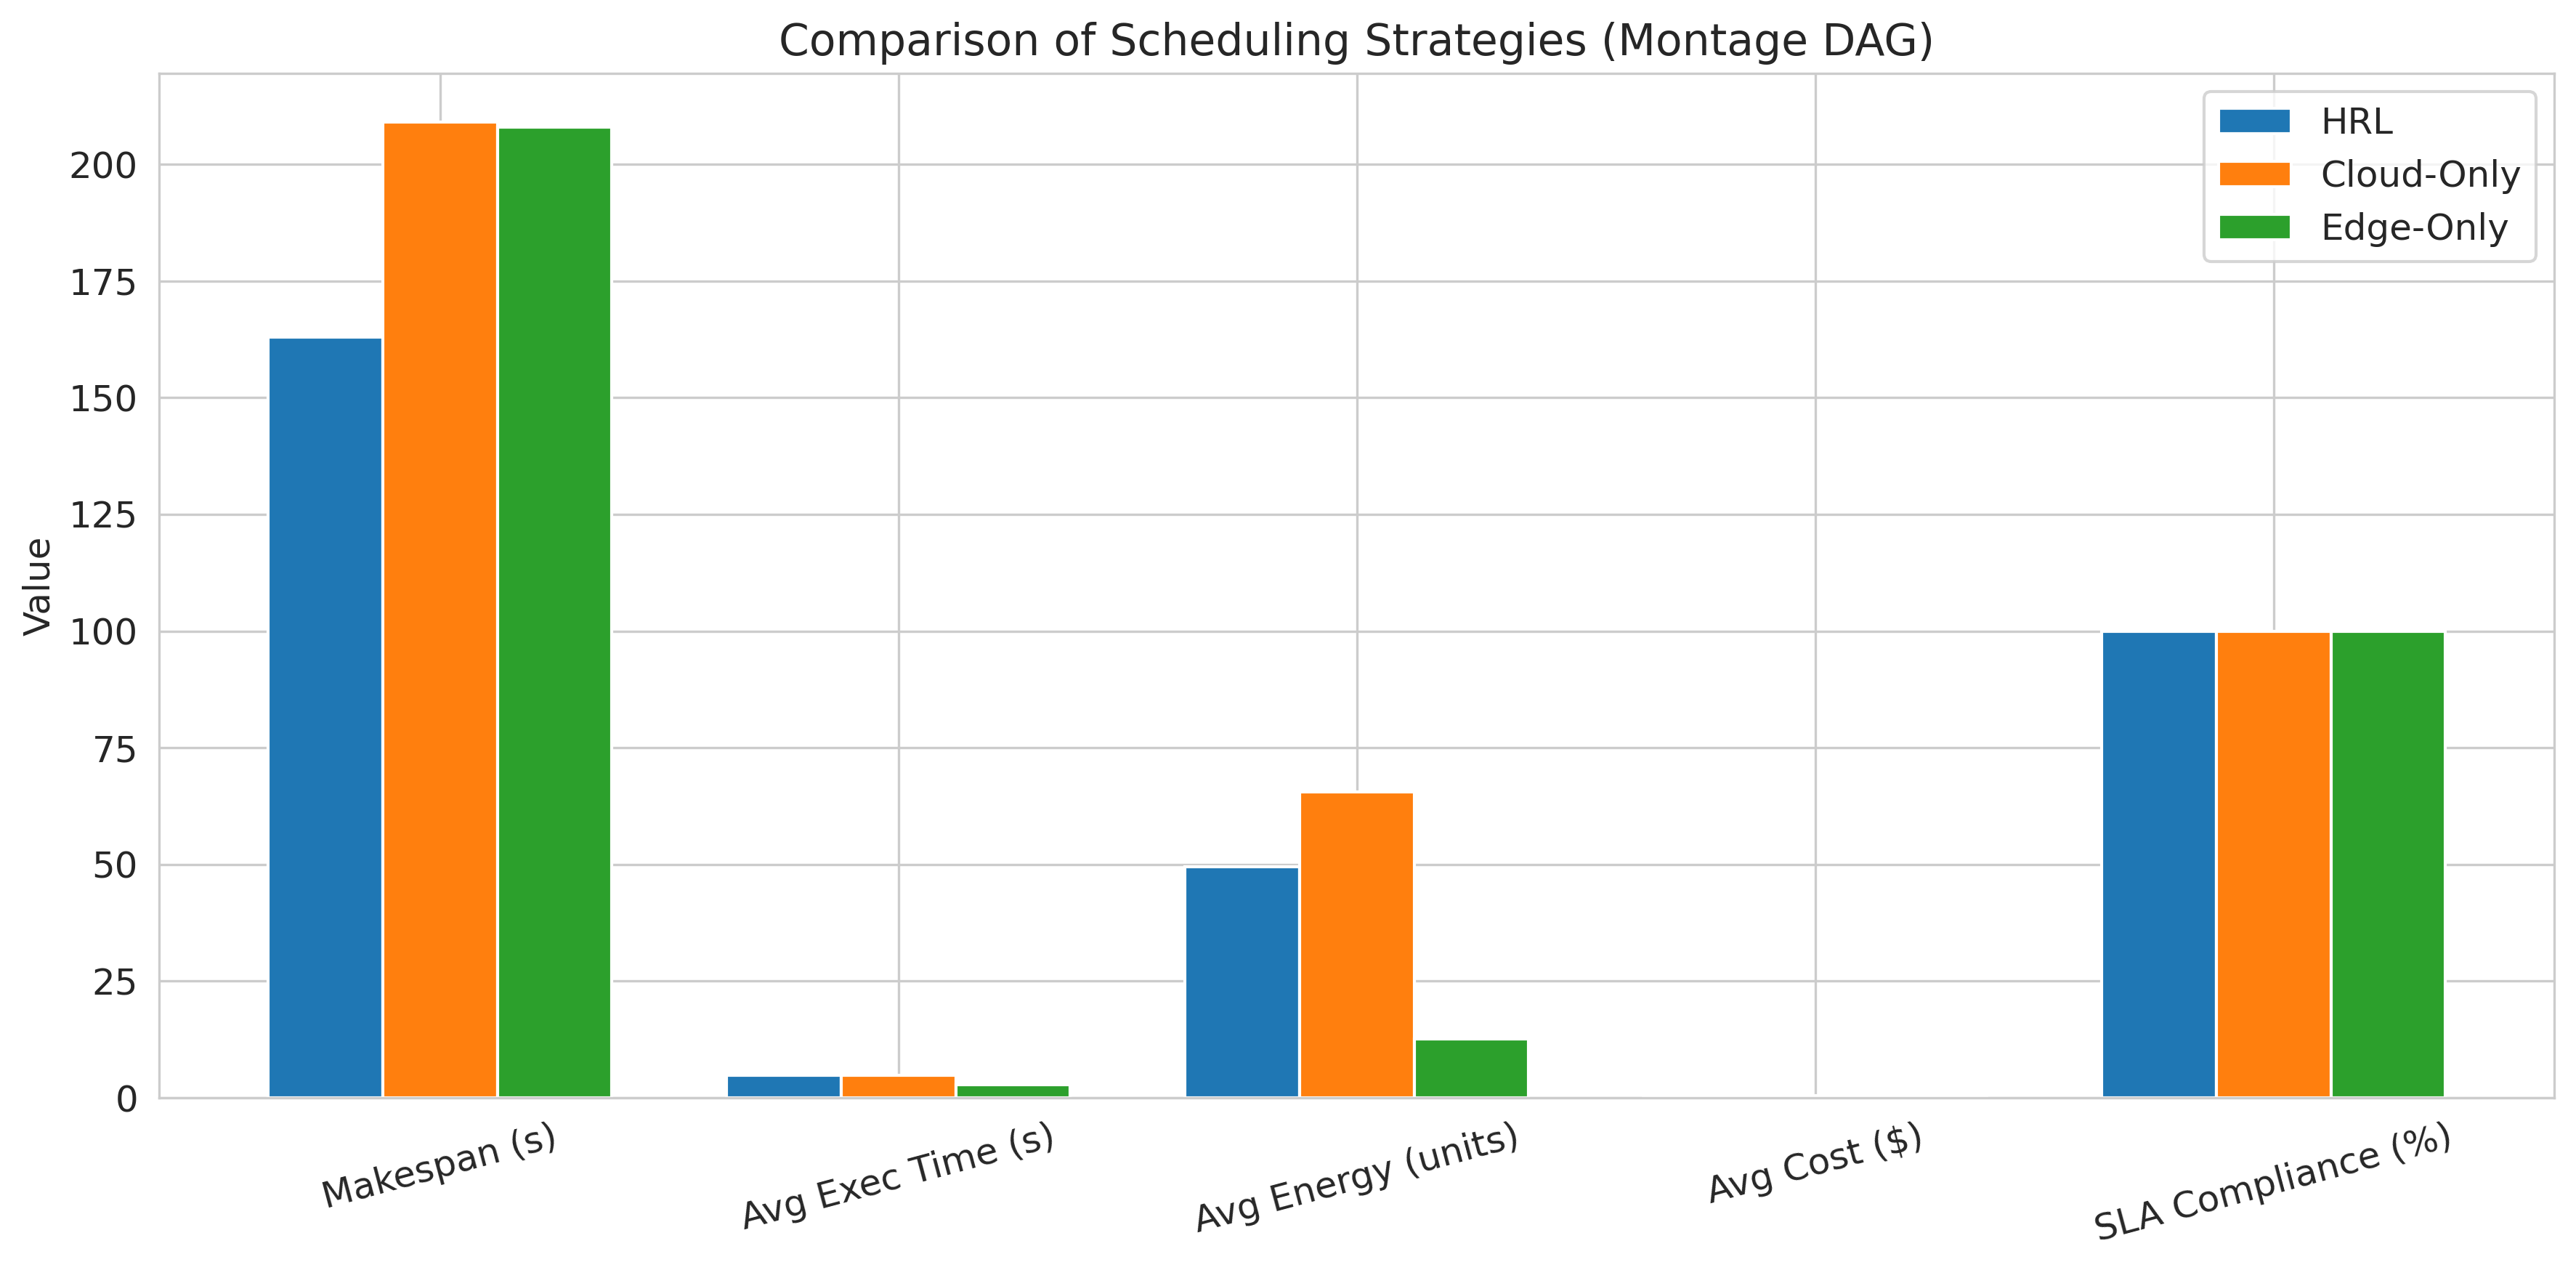

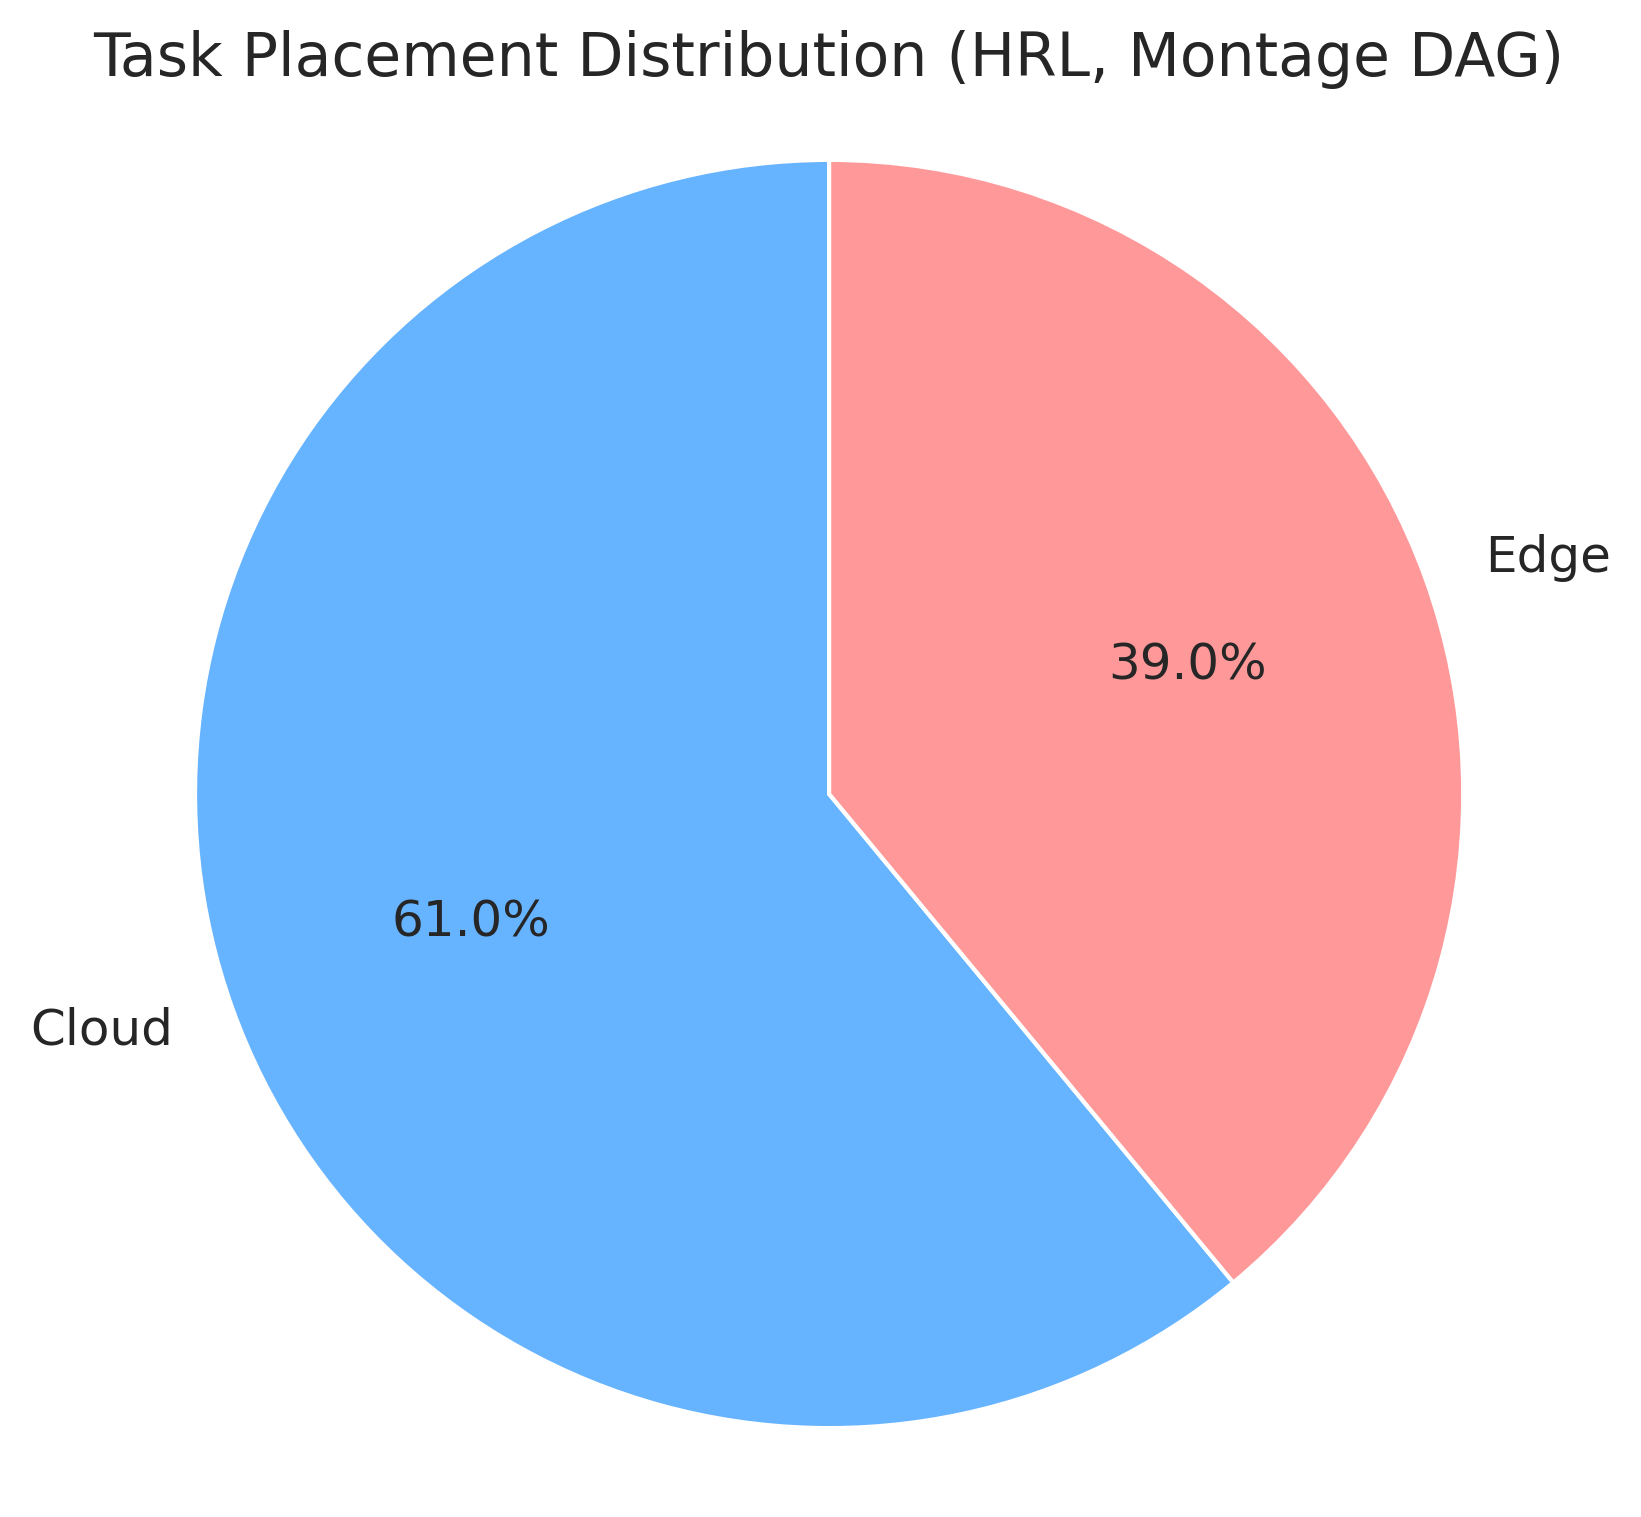

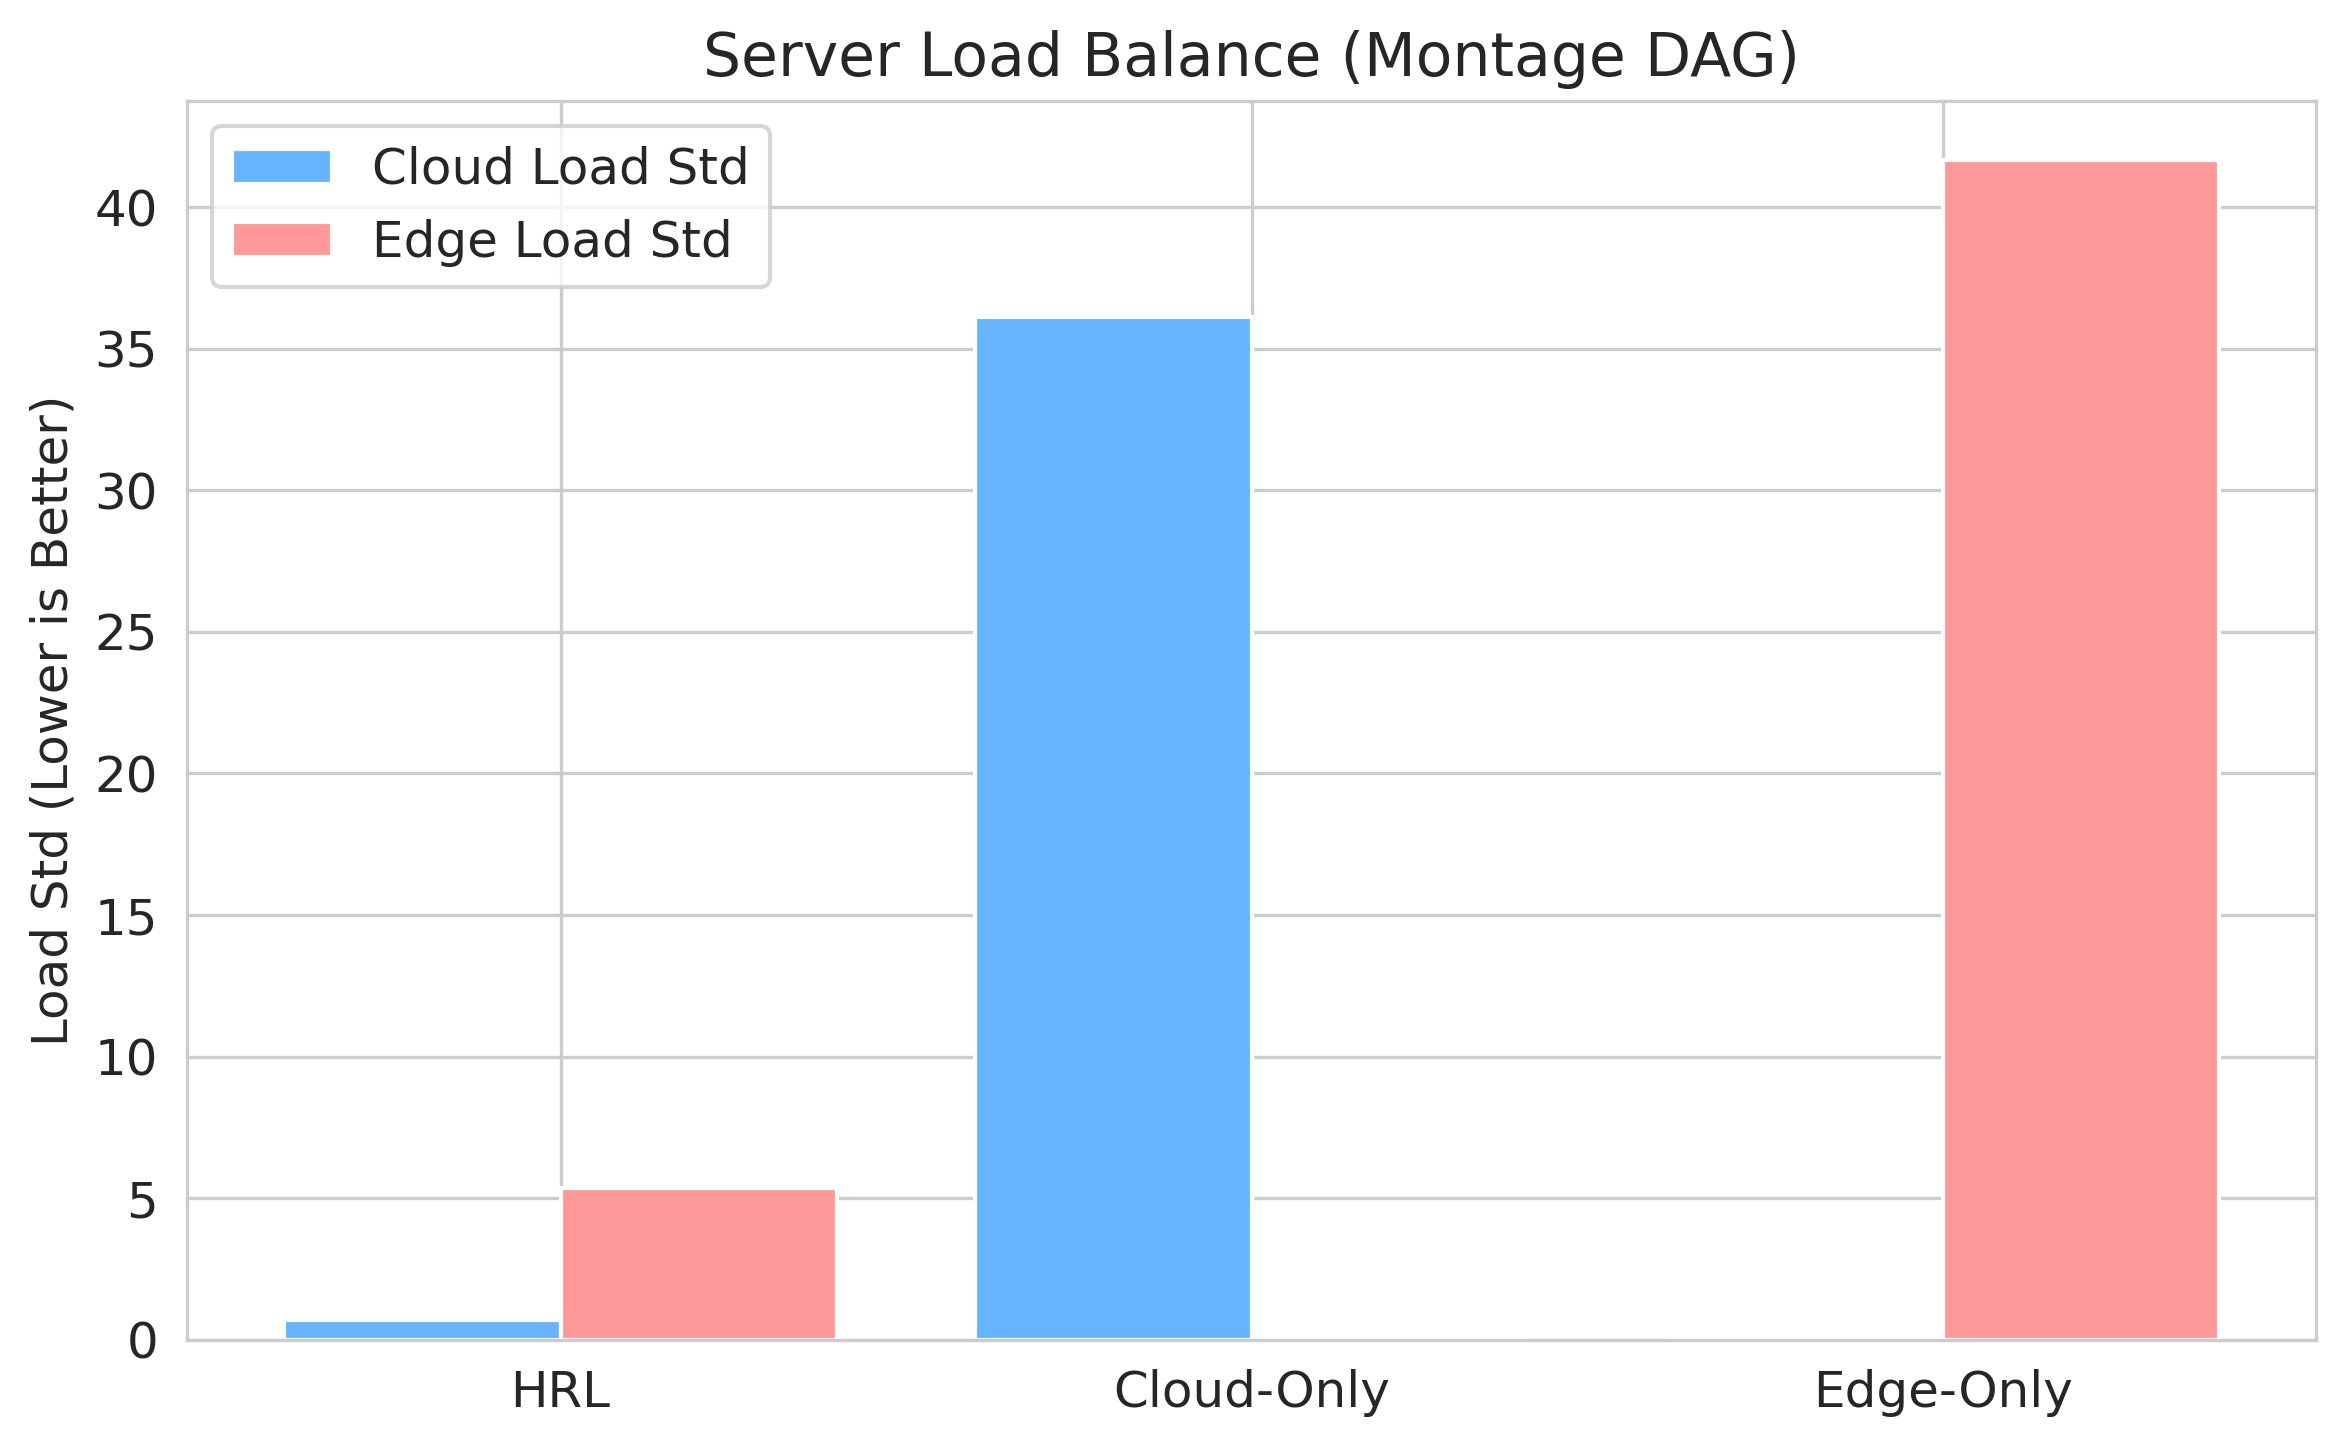

In [95]:
#showing the visualisations seperately
from IPython.display import Image, display
import os

def show_pngs(max_width=300):
    """Displays PNG images with a specified maximum width."""
    image_paths = [
        "metrics_comparison.png",
        "placement_distribution.png",
        "load_balance.png"
    ]
    for image_path in image_paths:
        if os.path.exists(image_path):
            display(Image(filename=image_path, width=max_width))
        else:
            print(f"Warning: Image file not found: {image_path}")
show_pngs(max_width=600)

In [96]:
import json
import os
from rich.console import Console
from rich.table import Table

# Print execution time and placement for tasks from schedule JSONs
def print_schedule_details(modes=["hrl", "cloud", "edge"]):
    console = Console()
    for mode in modes:
        filename = f"schedule_{mode}.json"
        # Check if schedule file exists
        if not os.path.exists(filename):
            console.log(f"Warning: {filename} not found for {mode.upper()}")
            continue
        # Load schedule JSON
        with open(filename, "r") as f:
            schedule = json.load(f)  # Dict: [num_tasks] keys
        if not schedule:
            console.log(f"Warning: {filename} is empty for {mode.upper()}")
            continue
        # Create table for display
        table = Table(title=f"Task Schedule ({mode.upper()}, Montage DAG)")
        table.add_column("Task ID", justify="center")
        table.add_column("Placement", justify="center")
        table.add_column("Execution Time (s)", justify="center")
        # Sort tasks by ID for consistent ordering
        sorted_tasks = sorted(schedule.items(), key=lambda x: x[0])  # List: [num_tasks, (task_id, dict)]
        for task_id, info in sorted_tasks:
            placement = info.get("placement", "N/A")
            exec_time = info.get("exec_time", 0.0)
            table.add_row(task_id, str(placement), f"{exec_time:.2f}")
        console.print(table)
        console.log(f"Displayed {len(schedule)} tasks for {mode.upper()}")

if __name__ == "__main__":
    # Execute for all modes
    print_schedule_details()  # Outputs tables for HRL, cloud, edge

      Task Schedule (HRL, Montage DAG)      
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ ID00001 │   edge    │        5.00        │
│ ID00003 │   cloud   │        5.00        │
│ ID00004 │   cloud   │        5.00        │
│ ID00005 │   cloud   │        5.00        │
│ ID00007 │   edge    │        4.65        │
│ ID00010 │   cloud   │        5.00        │
│ ID00011 │   edge    │        5.00        │
│ ID00012 │   edge    │        5.00        │
│ ID00013 │   cloud   │        5.00        │
│ ID00014 │   cloud   │        5.00        │
│ ID00015 │   cloud   │        5.00        │
│ ID00016 │   edge    │        5.00        │
│ ID00017 │   cloud   │        5.00        │
│ ID00018 │   edge    │        5.00        │
│ ID00021 │   cloud   │        5.00        │
│ ID00023 │   edge    │        5.00        │
│ ID00024 │   edge    │        5.00        │
│ ID00025 │   edge    │        4.91        │
│ ID00026 │   cloud   │        5.00        │
│ ID00027 │   cloud   │        5.00        │
│ ID00028 │   edge    │        5.00        │
│ ID00029 │   cloud   │        5.00        │
│ ID00030 │   edge    │        5.00        │
│ ID00031 │   cloud   │        5.00        │
│ ID00033 │   cloud   │        5.00        │
│ ID00034 │   cloud   │        4.83        │
│ ID00035 │   cloud   │        5.00        │
│ ID00036 │   cloud   │        5.00        │
│ ID00037 │   cloud   │        5.00        │
│ ID00039 │   cloud   │        5.00        │
│ ID00040 │   edge    │        5.00        │
│ ID00041 │   cloud   │        5.00        │
│ ID00043 │   edge    │        5.00        │
│ ID00044 │   cloud   │        5.00        │
│ ID00045 │   cloud   │        5.00        │
│ ID00046 │   cloud   │        5.00        │
│ ID00047 │   cloud   │        5.00        │
│ ID00048 │   edge    │        5.00        │
│ ID00049 │   edge    │        4.63        │
│ ID00051 │   cloud   │        5.00        │
│ ID00052 │   cloud   │        5.00        │
│ ID00055 │   cloud   │        5.00        │
│ ID00056 │   cloud   │        4.70        │
│ ID00058 │   edge    │        4.92        │
│ ID00059 │   cloud   │        5.00        │
│ ID00060 │   cloud   │        4.85        │
│ ID00061 │   cloud   │        5.00        │
│ ID00062 │   cloud   │        5.00        │
│ ID00063 │   cloud   │        5.00        │
│ ID00064 │   cloud   │        5.00        │
│ ID00065 │   cloud   │        5.00        │
│ ID00066 │   edge    │        5.00        │
│ ID00067 │   cloud   │        5.00        │
│ ID00069 │   cloud   │        5.00        │
│ ID00071 │   edge    │        5.00        │
│ ID00072 │   cloud   │        5.00        │
│ ID00074 │   edge    │        4.78        │
│ ID00075 │   cloud   │        5.00        │
│ ID00076 │   cloud   │        5.00        │
│ ID00077 │   cloud   │        5.00        │
│ ID00078 │   cloud   │        4.95        │
│ ID00079 │   cloud   │        5.00        │
│ ID00081 │   cloud   │        5.00        │
│ ID00082 │   cloud   │        5.00        │
│ ID00084 │   cloud   │        5.00        │
│ ID00085 │   edge    │        5.00        │
│ ID00086 │   cloud   │        4.93        │
│ ID00087 │   edge    │        5.00        │
│ ID00088 │   cloud   │        5.00        │
│ ID00089 │   edge    │        5.00        │
│ ID00090 │   cloud   │        5.00        │
│ ID00091 │   edge    │        4.88        │
│ ID00093 │   edge    │        5.00        │
│ ID00095 │   cloud   │        5.00        │
│ ID00096 │   cloud   │        5.00        │
│ ID00098 │   cloud   │        5.00        │
│ ID00099 │   edge    │        5.00        │
│ ID00100 │   cloud   │        5.00        │
│ ID00101 │   edge    │        5.00        │
│ ID00102 │   edge    │        5.00        │
│ ID00103 │   cloud   │        5.00        │
│ ID00104 │   cloud   │        5.00        │
│ ID00105 │   cloud   │        5.00        │
│ ID00106 │   cloud   │        5.00        │
│ ID00107 │   edge    │        5.00     

[20:03:34] Displayed 800 tasks for HRL                                           <ipython-input-96-3827beb8a594>:33

     Task Schedule (CLOUD, Montage DAG)     
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ ID00001 │   cloud   │        5.00        │
│ ID00003 │   cloud   │        5.00        │
│ ID00004 │   cloud   │        5.00        │
│ ID00005 │   cloud   │        5.00        │
│ ID00007 │   cloud   │        4.84        │
│ ID00010 │   cloud   │        5.00        │
│ ID00011 │   cloud   │        5.00        │
│ ID00012 │   cloud   │        5.00        │
│ ID00013 │   cloud   │        5.00        │
│ ID00014 │   cloud   │        5.00        │
│ ID00015 │   cloud   │        5.00        │
│ ID00016 │   cloud   │        5.00        │
│ ID00017 │   cloud   │        5.00        │
│ ID00018 │   cloud   │        5.00        │
│ ID00021 │   cloud   │        5.00        │
│ ID00023 │   cloud   │        5.00        │
│ ID00024 │   cloud   │        5.00        │
│ ID00025 │   cloud   │        5.00        │
│ ID00026 │   cloud   │        5.00        │
│ ID00027 │   cloud   │        5.00        │
│ ID00028 │   cloud   │        5.00        │
│ ID00029 │   cloud   │        5.00        │
│ ID00030 │   cloud   │        5.00        │
│ ID00031 │   cloud   │        5.00        │
│ ID00033 │   cloud   │        5.00        │
│ ID00034 │   cloud   │        5.00        │
│ ID00035 │   cloud   │        5.00        │
│ ID00036 │   cloud   │        5.00        │
│ ID00037 │   cloud   │        5.00        │
│ ID00039 │   cloud   │        5.00        │
│ ID00040 │   cloud   │        5.00        │
│ ID00041 │   cloud   │        5.00        │
│ ID00043 │   cloud   │        5.00        │
│ ID00044 │   cloud   │        5.00        │
│ ID00045 │   cloud   │        5.00        │
│ ID00046 │   cloud   │        5.00        │
│ ID00047 │   cloud   │        5.00        │
│ ID00048 │   cloud   │        5.00        │
│ ID00049 │   cloud   │        4.84        │
│ ID00051 │   cloud   │        5.00        │
│ ID00052 │   cloud   │        5.00        │
│ ID00055 │   cloud   │        5.00        │
│ ID00056 │   cloud   │        4.84        │
│ ID00058 │   cloud   │        5.00        │
│ ID00059 │   cloud   │        5.00        │
│ ID00060 │   cloud   │        5.00        │
│ ID00061 │   cloud   │        5.00        │
│ ID00062 │   cloud   │        5.00        │
│ ID00063 │   cloud   │        5.00        │
│ ID00064 │   cloud   │        5.00        │
│ ID00065 │   cloud   │        5.00        │
│ ID00066 │   cloud   │        5.00        │
│ ID00067 │   cloud   │        4.84        │
│ ID00069 │   cloud   │        5.00        │
│ ID00071 │   cloud   │        5.00        │
│ ID00072 │   cloud   │        5.00        │
│ ID00074 │   cloud   │        5.00        │
│ ID00075 │   cloud   │        5.00        │
│ ID00076 │   cloud   │        5.00        │
│ ID00077 │   cloud   │        5.00        │
│ ID00078 │   cloud   │        5.00        │
│ ID00079 │   cloud   │        5.00        │
│ ID00081 │   cloud   │        5.00        │
│ ID00082 │   cloud   │        5.00        │
│ ID00084 │   cloud   │        5.00        │
│ ID00085 │   cloud   │        5.00        │
│ ID00086 │   cloud   │        5.00        │
│ ID00087 │   cloud   │        5.00        │
│ ID00088 │   cloud   │        5.00        │
│ ID00089 │   cloud   │        5.00        │
│ ID00090 │   cloud   │        5.00        │
│ ID00091 │   cloud   │        5.00        │
│ ID00093 │   cloud   │        5.00        │
│ ID00095 │   cloud   │        5.00        │
│ ID00096 │   cloud   │        5.00        │
│ ID00098 │   cloud   │        5.00        │
│ ID00099 │   cloud   │        5.00        │
│ ID00100 │   cloud   │        5.00        │
│ ID00101 │   cloud   │        5.00        │
│ ID00102 │   cloud   │        5.00        │
│ ID00103 │   cloud   │        5.00        │
│ ID00104 │   cloud   │        5.00        │
│ ID00105 │   cloud   │        5.00        │
│ ID00106 │   cloud   │        5.00        │
│ ID00107 │   cloud   │        5.00     

           Displayed 800 tasks for CLOUD                                         <ipython-input-96-3827beb8a594>:33

     Task Schedule (EDGE, Montage DAG)      
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ ID00001 │   edge    │        2.30        │
│ ID00003 │   edge    │        2.39        │
│ ID00004 │   edge    │        2.39        │
│ ID00005 │   edge    │        2.39        │
│ ID00007 │   edge    │        4.84        │
│ ID00010 │   edge    │        2.30        │
│ ID00011 │   edge    │        2.39        │
│ ID00012 │   edge    │        5.00        │
│ ID00013 │   edge    │        2.39        │
│ ID00014 │   edge    │        2.39        │
│ ID00015 │   edge    │        2.39        │
│ ID00016 │   edge    │        5.00        │
│ ID00017 │   edge    │        2.39        │
│ ID00018 │   edge    │        2.39        │
│ ID00021 │   edge    │        2.39        │
│ ID00023 │   edge    │        2.39        │
│ ID00024 │   edge    │        2.39        │
│ ID00025 │   edge    │        5.00        │
│ ID00026 │   edge    │        2.39        │
│ ID00027 │   edge    │        2.39        │
│ ID00028 │   edge    │        2.39        │
│ ID00029 │   edge    │        2.42        │
│ ID00030 │   edge    │        2.39        │
│ ID00031 │   edge    │        2.39        │
│ ID00033 │   edge    │        2.39        │
│ ID00034 │   edge    │        5.00        │
│ ID00035 │   edge    │        5.00        │
│ ID00036 │   edge    │        2.39        │
│ ID00037 │   edge    │        2.30        │
│ ID00039 │   edge    │        2.39        │
│ ID00040 │   edge    │        2.30        │
│ ID00041 │   edge    │        2.42        │
│ ID00043 │   edge    │        2.39        │
│ ID00044 │   edge    │        2.39        │
│ ID00045 │   edge    │        2.39        │
│ ID00046 │   edge    │        2.39        │
│ ID00047 │   edge    │        2.39        │
│ ID00048 │   edge    │        2.39        │
│ ID00049 │   edge    │        4.84        │
│ ID00051 │   edge    │        2.39        │
│ ID00052 │   edge    │        5.00        │
│ ID00055 │   edge    │        2.42        │
│ ID00056 │   edge    │        4.84        │
│ ID00058 │   edge    │        5.00        │
│ ID00059 │   edge    │        2.39        │
│ ID00060 │   edge    │        5.00        │
│ ID00061 │   edge    │        2.39        │
│ ID00062 │   edge    │        2.30        │
│ ID00063 │   edge    │        2.39        │
│ ID00064 │   edge    │        2.39        │
│ ID00065 │   edge    │        2.39        │
│ ID00066 │   edge    │        5.00        │
│ ID00067 │   edge    │        4.84        │
│ ID00069 │   edge    │        2.39        │
│ ID00071 │   edge    │        2.39        │
│ ID00072 │   edge    │        2.39        │
│ ID00074 │   edge    │        5.00        │
│ ID00075 │   edge    │        5.00        │
│ ID00076 │   edge    │        2.39        │
│ ID00077 │   edge    │        5.00        │
│ ID00078 │   edge    │        5.00        │
│ ID00079 │   edge    │        2.30        │
│ ID00081 │   edge    │        2.39        │
│ ID00082 │   edge    │        2.39        │
│ ID00084 │   edge    │        5.00        │
│ ID00085 │   edge    │        2.39        │
│ ID00086 │   edge    │        5.00        │
│ ID00087 │   edge    │        2.30        │
│ ID00088 │   edge    │        2.39        │
│ ID00089 │   edge    │        2.39        │
│ ID00090 │   edge    │        2.39        │
│ ID00091 │   edge    │        5.00        │
│ ID00093 │   edge    │        2.39        │
│ ID00095 │   edge    │        2.39        │
│ ID00096 │   edge    │        2.39        │
│ ID00098 │   edge    │        2.39        │
│ ID00099 │   edge    │        2.39        │
│ ID00100 │   edge    │        2.39        │
│ ID00101 │   edge    │        2.39        │
│ ID00102 │   edge    │        2.39        │
│ ID00103 │   edge    │        2.39        │
│ ID00104 │   edge    │        2.39        │
│ ID00105 │   edge    │        2.39        │
│ ID00106 │   edge    │        5.00        │
│ ID00107 │   edge    │        2.39     

[20:03:35] Displayed 800 tasks for EDGE                                          <ipython-input-96-3827beb8a594>:33

Precision: 0.5039

Recall:    0.4000

F1-Score:  0.4460

ROC AUC:   0.5056

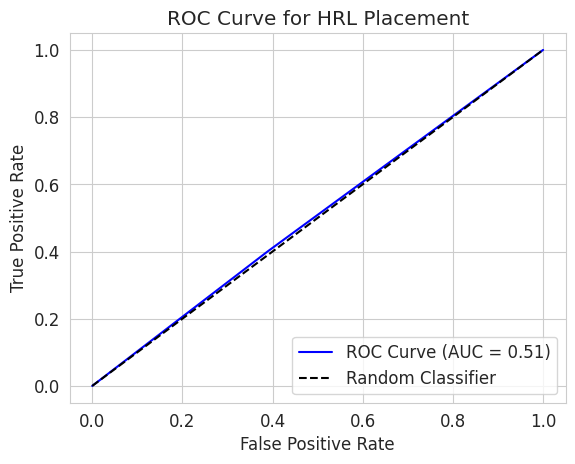

    Confusion Matrix: HRL     
  Placements vs. CyberShake   
           Dataset            
┏━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━┓
┃ True \ Pred ┃ Cloud ┃ Edge ┃
┡━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━┩
│ True Cloud  │  198  │ 126  │
│  True Edge  │  192  │ 128  │
└─────────────┴───────┴──────┘

Placement Accuracy (HRL vs. CyberShake Dataset): 50.62%

In [97]:
import json
import os
from rich.console import Console
from rich.table import Table
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def compute_placement_confusion_matrix(dag_file="balanced_cybershake_dag.json", schedule_file="schedule_hrl.json"):
    console = Console()

    try:
        # Load DAG for true placements
        with open(dag_file, "r") as f:
            dag_json = json.load(f)
        true_placements = {node["id"]: node.get("machine_type", "unknown") for node in dag_json.get("nodes", [])}

        # Load HRL schedule for predicted placements
        with open(schedule_file, "r") as f:
            hrl_schedule = json.load(f)

            # Create binary labels: edge = 1, cloud = 0
        label_map = {"cloud": 0, "edge": 1}
        y_true = []
        y_pred = []

        for tid in hrl_schedule:
            if tid in true_placements:
                true_placement = true_placements[tid]
                pred_placement = hrl_schedule[tid]["placement"]
                if true_placement in label_map and pred_placement in label_map:
                    y_true.append(label_map[true_placement])
                    y_pred.append(label_map[pred_placement])

        # Compute metrics
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)  # Note: only valid if binary classification

        # Print metrics
        console.print(f"Precision: {precision:.4f}")
        console.print(f"Recall:    {recall:.4f}")
        console.print(f"F1-Score:  {f1:.4f}")
        console.print(f"ROC AUC:   {roc_auc:.4f}")

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for HRL Placement')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

        # Initialize confusion matrix (2x2: cloud vs. edge)
        cm = {"cloud": {"cloud": 0, "edge": 0}, "edge": {"cloud": 0, "edge": 0}}
        for tid in hrl_schedule:
            if tid in true_placements:
                true_placement = true_placements[tid]
                pred_placement = hrl_schedule[tid]["placement"]
                if true_placement in cm and pred_placement in cm[true_placement]:
                    cm[true_placement][pred_placement] += 1

        # Display confusion matrix
        cm_table = Table(title="Confusion Matrix: HRL Placements vs. CyberShake Dataset")
        cm_table.add_column("True \\ Pred", justify="center")
        cm_table.add_column("Cloud", justify="center")
        cm_table.add_column("Edge", justify="center")
        for true_label in ["cloud", "edge"]:
            row = [f"True {true_label.capitalize()}"]
            row.extend([str(cm[true_label][pred_label]) for pred_label in ["cloud", "edge"]])
            cm_table.add_row(*row)
        console.print(cm_table)

        # Calculate and display accuracy
        total = sum(sum(cm[row].values()) for row in cm)
        correct = cm["cloud"]["cloud"] + cm["edge"]["edge"]
        accuracy = correct / total if total > 0 else 0
        console.print(f"Placement Accuracy (HRL vs. CyberShake Dataset): {accuracy:.2%}")

    except Exception as e:
        console.print(f"Error computing confusion matrix: {e}")

if __name__ == "__main__":
    compute_placement_confusion_matrix()



In [ ]:
import json
import networkx as nx
import numpy as np
import torch
import os
from rich.console import Console
from rich.table import Table

# SJFScheduler: Shortest Job First scheduler for edge-cloud tasks
class SJFScheduler:
    def __init__(self, dag_file="balanced_montage_dag.json", embeddings_file="montage_embeddings.pth", max_nodes=1000):
        # Initialize SJF scheduler
        # Inputs:
        #   dag_file: Path to Montage DAG
        #   embeddings_file: Path to Montage embeddings
        #   max_nodes: Max nodes per DAG (default 1000)
        self.dag_file = dag_file  # Scalar
        self.embeddings_file = embeddings_file  # Scalar
        self.max_nodes = max_nodes  # Scalar
        self.console = Console()
        self.dag, self.embeddings, self.task_ids = self.load_dag_and_embeddings()  # dag: NetworkX, embeddings: [num_nodes, 32], task_ids: [num_nodes]
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)  # TaskQueue instance
        self.metrics = None  # Dict or None

    def load_dag_and_embeddings(self):
        # Load Montage DAG and embeddings
        # Returns: dag (NetworkX), embeddings [num_nodes, 32], task_ids [num_nodes]
        if not os.path.exists(self.dag_file):
            self.console.log(f"Error: DAG file {self.dag_file} not found")
            raise FileNotFoundError(f"DAG file {self.dag_file} not found")
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)  # Dict
        dag = nx.node_link_graph(dag_json, edges="links")  # NetworkX DAG
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()  # Subgraph
        if not os.path.exists(self.embeddings_file):
            self.console.log(f"Warning: Embeddings file {self.embeddings_file} not found, using zeros")
            task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}  # Dict: [num_nodes]
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
        embeddings_data = torch.load(self.embeddings_file, map_location=torch.device('cpu'))  # Dict
        task_embeddings_dict = embeddings_data["task_embeddings"]  # Dict: [num_nodes]
        task_ids = list(dag.nodes())  # [num_nodes]
        task_embeddings = np.array([
            task_embeddings_dict.get(tid, {"mean": np.zeros(32)}).get("mean", np.zeros(32)) for tid in task_ids
        ])  # [num_nodes, 32]
        return dag, task_embeddings, task_ids

    def schedule(self):
        # Schedule tasks using SJF, selecting shortest exec_time
        # Returns: Metrics dict
        self.task_queue.reset()
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = 0
        queue_lengths = []  # List
        cloud_tasks = 0
        max_steps = len(self.task_ids) * 10
        step = 0
        total_reward = 0
        while len(self.task_queue.completed) < len(self.task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))  # List append
            ready_tasks = self.task_queue.get_ready_tasks()  # List
            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                   if t["arrival_time"] > self.task_queue.current_time and
                                   t["dependencies"].issubset(self.task_queue.completed)]  # List
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)  # Scalar
                    continue
                self.console.log(f"Validation stopped: {len(self.task_ids) - len(self.task_queue.completed)} tasks incomplete")
                break
            ready_tasks = sorted(ready_tasks, key=lambda tid: self.task_queue.tasks[tid]["exec_time"])  # List: [num_ready]
            self.task_queue.update_conditions()
            for tid in ready_tasks[:1]:
                base_time = self.task_queue.tasks[tid]["exec_time"]  # Scalar
                best_exec_time = float('inf')
                best_placement = None
                best_server = None
                for placement in ["cloud", "edge"]:
                    if placement == "edge" and np.mean(self.task_queue.edge_battery) < 20:  # [5]
                        continue
                    for server in range(len(self.task_queue.server_loads[placement])):
                        load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)  # Scalar
                        exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                        exec_time = min(exec_time, 5.0)  # Scalar
                        if exec_time < best_exec_time:
                            best_exec_time = exec_time
                            best_placement = placement
                            best_server = server
                if best_placement is None:
                    best_placement = "cloud"
                    best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))  # Scalar from [5]
                    load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)  # Scalar
                    best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                    best_exec_time = min(best_exec_time, 5.0)  # Scalar
                base_power = (self.task_queue.cloud_base_power[best_server] if best_placement == "cloud"
                              else self.task_queue.edge_base_power[best_server])  # Scalar
                energy = (base_power + load_factor * 5) * best_exec_time  # Scalar
                cost = best_exec_time * (0.10 if best_placement == "cloud" else 0.05)  # Scalar
                sla_met = 1 if best_exec_time <= base_time * 1.5 else 0  # Scalar
                self.task_queue.start_task(tid, best_placement, best_server, best_exec_time)
                tasks_started += 1
                total_exec_time += best_exec_time
                total_energy += energy
                total_cost += cost
                sla_compliance += sla_met
                if best_placement == "cloud":
                    cloud_tasks += 1
                total_reward += (30.0 * sla_met - 0.1 * (best_exec_time / 5.0) - 0.05 * (energy / 5.0))
            step += 1
        self.save_schedule()
        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0  # Scalar
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])  # Scalar from [5]
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])  # Scalar from [5]
        avg_edge_battery = np.mean(self.task_queue.edge_battery)  # Scalar from [5]
        avg_reward = total_reward / step if step > 0 else 0
        cloud_ratio = cloud_tasks / tasks_started if tasks_started > 0 else 0
        avg_exec_time = total_exec_time / tasks_started if tasks_started else 0
        avg_energy = total_energy / tasks_started if tasks_started else 0
        avg_cost = total_cost / tasks_started if tasks_started else 0
        sla_rate = sla_compliance / tasks_started if tasks_started > 0 else 0
        self.metrics = {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": avg_exec_time,
            "avg_energy": avg_energy,
            "avg_cost": avg_cost,
            "sla_rate": sla_rate,
            "cloud_ratio": cloud_ratio,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(self.task_ids)
        }  # Dict
        self.console.log(f"SJF Metrics: Makespan={self.metrics['makespan']:.2f}s, SLA={self.metrics['sla_rate']:.2%}")
        return self.metrics

    def save_schedule(self):
        # Save SJF schedule with completion timestamp
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"] if task["history"] else "N/A",
                "server": int(task["history"][-1]["server"]) if task["history"] else -1,
                "exec_time": float(task["history"][-1]["exec_time"]) if task["history"] else 0.0,
                "timestamp": float(task["history"][-1]["timestamp"]) if task["history"] else 0.0  # Completion time
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }  # Dict: [num_completed]
        filename = "schedule_sjf.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved SJF schedule with {len(schedule)} tasks to {filename}")

In [ ]:
import json
import networkx as nx
import numpy as np
import torch
import os
from rich.console import Console
from rich.table import Table

# HEFTScheduler: Heterogeneous Earliest Finish Time scheduler for edge-cloud tasks
class HEFTScheduler:
    def __init__(self, dag_file="balanced_montage_dag.json", embeddings_file="montage_embeddings.pth", max_nodes=1000):
        # Initialize HEFT scheduler
        # Inputs:
        #   dag_file: Path to Montage DAG
        #   embeddings_file: Path to Montage embeddings
        #   max_nodes: Max nodes per DAG (default 1000)
        self.dag_file = dag_file  # Scalar
        self.embeddings_file = embeddings_file  # Scalar
        self.max_nodes = max_nodes  # Scalar
        self.console = Console()
        self.dag, self.embeddings, self.task_ids = self.load_dag_and_embeddings()  # dag: NetworkX, embeddings: [num_nodes, 32], task_ids: [num_nodes]
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)  # TaskQueue instance
        self.metrics = None  # Dict or None

    def load_dag_and_embeddings(self):
        # Load Montage DAG and embeddings
        # Returns: dag (NetworkX), embeddings [num_nodes, 32], task_ids [num_nodes]
        if not os.path.exists(self.dag_file):
            self.console.log(f"Error: DAG file {self.dag_file} not found")
            raise FileNotFoundError(f"DAG file {self.dag_file} not found")
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)  # Dict
        dag = nx.node_link_graph(dag_json, edges="links")  # NetworkX DAG
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()  # Subgraph
        if not os.path.exists(self.embeddings_file):
            self.console.log(f"Warning: Embeddings file {self.embeddings_file} not found, using zeros")
            task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}  # Dict: [num_nodes]
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
        embeddings_data = torch.load(self.embeddings_file, map_location=torch.device('cpu'))  # Dict
        task_embeddings_dict = embeddings_data["task_embeddings"]  # Dict: [num_nodes]
        task_ids = list(dag.nodes())  # [num_nodes]
        task_embeddings = np.array([
            task_embeddings_dict.get(tid, {"mean": np.zeros(32)}).get("mean", np.zeros(32)) for tid in task_ids
        ])  # [num_nodes, 32]
        return dag, task_embeddings, task_ids

    def compute_ranks(self):
        # Compute upward ranks for tasks based on execution and communication times
        # Returns: Sorted task IDs [num_nodes]
        ranks = {}  # Dict: [num_nodes]
        exit_nodes = [n for n in self.dag.nodes if self.dag.out_degree(n) == 0]  # List
        def avg_exec_time(tid):
            return self.dag.nodes[tid].get("execution_time", 1.0)  # Scalar
        def avg_comm_time(src, dst):
            return self.dag.edges.get((src, dst), {}).get("T_comm", 0.1)  # Scalar
        def compute_rank(tid):
            if tid in ranks:
                return ranks[tid]
            if self.dag.out_degree(tid) == 0:
                ranks[tid] = avg_exec_time(tid)
                return ranks[tid]
            max_successor = 0
            for succ in self.dag.successors(tid):
                succ_rank = compute_rank(succ)  # Scalar
                comm_cost = avg_comm_time(tid, succ)  # Scalar
                max_successor = max(max_successor, comm_cost + succ_rank)
            ranks[tid] = avg_exec_time(tid) + max_successor
            return ranks[tid]
        for tid in self.task_ids:
            compute_rank(tid)
        return sorted(self.task_ids, key=lambda tid: ranks[tid], reverse=True)  # [num_nodes]

    def schedule(self):
        # Schedule tasks using HEFT, minimizing earliest finish time
        # Returns: Metrics dict
        self.task_queue.reset()
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = 0
        queue_lengths = []  # List
        cloud_tasks = 0
        max_steps = len(self.task_ids) * 10
        step = 0
        total_reward = 0
        task_order = self.compute_ranks()  # [num_nodes]
        scheduled_tasks = set()
        while len(self.task_queue.completed) < len(self.task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))  # List append
            ready_tasks = self.task_queue.get_ready_tasks()  # List
            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                   if t["arrival_time"] > self.task_queue.current_time and
                                   t["dependencies"].issubset(self.task_queue.completed)]  # List
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)  # Scalar
                    continue
                self.console.log(f"Validation stopped: {len(self.task_ids) - len(self.task_queue.completed)} tasks incomplete")
                break
            self.task_queue.update_conditions()
            ready_ranks = [(tid, task_order.index(tid)) for tid in ready_tasks if tid not in scheduled_tasks]  # List: [num_ready, (tid, index)]
            if not ready_ranks:
                self.task_queue.current_time += 0.5
                step += 1
                continue
            tid = min(ready_ranks, key=lambda x: x[1])[0]  # Scalar
            scheduled_tasks.add(tid)
            base_time = self.task_queue.tasks[tid]["exec_time"]  # Scalar
            earliest_finish = float('inf')
            best_placement = None
            best_server = None
            start_time = max([self.task_queue.current_time] +
                             [self.task_queue.tasks[dep]["history"][-1]["timestamp"] +
                              self.dag.edges.get((dep, tid), {}).get("T_comm", 0.1)
                              for dep in self.task_queue.tasks[tid]["dependencies"]
                              if self.task_queue.tasks[dep]["history"]])  # Scalar
            for placement in ["cloud", "edge"]:
                if placement == "edge" and np.mean(self.task_queue.edge_battery) < 20:  # [5]
                    continue
                for server in range(len(self.task_queue.server_loads[placement])):
                    load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)  # Scalar
                    exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                    exec_time = min(exec_time, 5.0)  # Scalar
                    finish_time = start_time + exec_time
                    if finish_time < earliest_finish:
                        earliest_finish = finish_time
                        best_placement = placement
                        best_server = server
                        best_exec_time = exec_time
            if best_placement is None:
                best_placement = "cloud"
                best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))  # Scalar from [5]
                load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)  # Scalar
                best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                best_exec_time = min(best_exec_time, 5.0)  # Scalar
            base_power = (self.task_queue.cloud_base_power[best_server] if best_placement == "cloud"
                          else self.task_queue.edge_base_power[best_server])  # Scalar
            energy = (base_power + load_factor * 5) * best_exec_time  # Scalar
            cost = best_exec_time * (0.10 if best_placement == "cloud" else 0.05)  # Scalar
            sla_met = 1 if best_exec_time <= base_time * 1.5 else 0  # Scalar
            self.task_queue.start_task(tid, best_placement, best_server, best_exec_time)
            tasks_started += 1
            total_exec_time += best_exec_time
            total_energy += energy
            total_cost += cost
            sla_compliance += sla_met
            if best_placement == "cloud":
                cloud_tasks += 1
            total_reward += (30.0 * sla_met - 0.1 * (best_exec_time / 5.0) - 0.05 * (energy / 5.0))
            step += 1
        self.save_schedule()
        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0  # Scalar
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])  # Scalar from [5]
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])  # Scalar from [5]
        avg_edge_battery = np.mean(self.task_queue.edge_battery)  # Scalar from [5]
        avg_reward = total_reward / step if step > 0 else 0
        cloud_ratio = cloud_tasks / tasks_started if tasks_started > 0 else 0
        avg_exec_time = total_exec_time / tasks_started if tasks_started else 0
        avg_energy = total_energy / tasks_started if tasks_started else 0
        avg_cost = total_cost / tasks_started if tasks_started else 0
        sla_rate = sla_compliance / tasks_started if tasks_started > 0 else 0
        self.metrics = {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": avg_exec_time,
            "avg_energy": avg_energy,
            "avg_cost": avg_cost,
            "sla_rate": sla_rate,
            "cloud_ratio": cloud_ratio,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(self.task_ids)
        }  # Dict
        self.console.log(f"HEFT Metrics: Makespan={self.metrics['makespan']:.2f}s, SLA={self.metrics['sla_rate']:.2%}")
        return self.metrics

    def save_schedule(self):
        # Save HEFT schedule with completion timestamp
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"] if task["history"] else "N/A",
                "server": int(task["history"][-1]["server"]) if task["history"] else -1,
                "exec_time": float(task["history"][-1]["exec_time"]) if task["history"] else 0.0,
                "timestamp": float(task["history"][-1]["timestamp"]) if task["history"] else 0.0  # Completion time
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }  # Dict: [num_completed]
        filename = "schedule_heft.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved HEFT schedule with {len(schedule)} tasks to {filename}")

In [ ]:
import json
import networkx as nx
import numpy as np
import torch
import os
from rich.console import Console
from rich.table import Table

# CriticalPathScheduler: Critical Path Method scheduler for edge-cloud tasks
class CriticalPathScheduler:
    def __init__(self, dag_file="balanced_montage_dag.json", embeddings_file="montage_embeddings.pth", max_nodes=1000):
        # Initialize CPM scheduler
        # Inputs:
        #   dag_file: Path to Montage DAG
        #   embeddings_file: Path to Montage embeddings
        #   max_nodes: Max nodes per DAG (default 1000)
        self.dag_file = dag_file  # Scalar
        self.embeddings_file = embeddings_file  # Scalar
        self.max_nodes = max_nodes  # Scalar
        self.console = Console()
        self.dag, self.embeddings, self.task_ids = self.load_dag_and_embeddings()  # dag: NetworkX, embeddings: [num_nodes, 32], task_ids: [num_nodes]
        self.task_queue = TaskQueue(self.dag, self.embeddings, self.task_ids)  # TaskQueue instance
        self.metrics = None  # Dict or None
        self.critical_path = self.compute_critical_path()  # Set: [num_critical]

    def load_dag_and_embeddings(self):
        # Load Montage DAG and embeddings
        # Returns: dag (NetworkX), embeddings [num_nodes, 32], task_ids [num_nodes]
        if not os.path.exists(self.dag_file):
            self.console.log(f"Error: DAG file {self.dag_file} not found")
            raise FileNotFoundError(f"DAG file {self.dag_file} not found")
        with open(self.dag_file, "r") as f:
            dag_json = json.load(f)  # Dict
        dag = nx.node_link_graph(dag_json, edges="links")  # NetworkX DAG
        if len(dag.nodes) > self.max_nodes:
            nodes = list(dag.nodes)[:self.max_nodes]
            dag = dag.subgraph(nodes).copy()  # Subgraph
        if not os.path.exists(self.embeddings_file):
            self.console.log(f"Warning: Embeddings file {self.embeddings_file} not found, using zeros")
            task_embeddings_dict = {tid: {"mean": np.zeros(32), "uncertainty": np.zeros(32)} for tid in dag.nodes()}  # Dict: [num_nodes]
            torch.save({"task_embeddings": task_embeddings_dict}, self.embeddings_file)
        embeddings_data = torch.load(self.embeddings_file, map_location=torch.device('cpu'))  # Dict
        task_embeddings_dict = embeddings_data["task_embeddings"]  # Dict: [num_nodes]
        task_ids = list(dag.nodes())  # [num_nodes]
        task_embeddings = np.array([
            task_embeddings_dict.get(tid, {"mean": np.zeros(32)}).get("mean", np.zeros(32)) for tid in task_ids
        ])  # [num_nodes, 32]
        return dag, task_embeddings, task_ids

    def compute_critical_path(self):
        # Compute critical path based on execution and communication times
        # Returns: Set of critical task IDs [num_critical]
        longest_path = []
        max_length = 0
        exit_nodes = [n for n in self.dag.nodes if self.dag.out_degree(n) == 0]  # List
        entry_nodes = [n for n in self.dag.nodes if self.dag.in_degree(n) == 0]  # List
        def path_length(path):
            length = sum(self.dag.nodes[n].get("execution_time", 1.0) for n in path)  # Scalar
            for i in range(len(path) - 1):
                length += self.dag.edges.get((path[i], path[i+1]), {}).get("T_comm", 0.1)  # Scalar
            return length
        def find_paths(current, target, path, all_paths):
            if current == target:
                all_paths.append(path[:])
                return
            for succ in self.dag.successors(current):
                path.append(succ)
                find_paths(succ, target, path, all_paths)
                path.pop()
        critical_path = []
        for entry in entry_nodes:
            for exit in exit_nodes:
                all_paths = []
                find_paths(entry, exit, [entry], all_paths)  # List: [num_paths, path]
                for p in all_paths:
                    length = path_length(p)
                    if length > max_length:
                        max_length = length
                        critical_path = p
        return set(critical_path)  # Set: [num_critical]

    def schedule(self):
        # Schedule tasks using CPM, prioritizing critical path on cloud
        # Returns: Metrics dict
        self.task_queue.reset()
        total_exec_time = total_energy = total_cost = sla_compliance = tasks_started = 0
        queue_lengths = []  # List
        cloud_tasks = 0
        max_steps = len(self.task_ids) * 10
        step = 0
        total_reward = 0
        while len(self.task_queue.completed) < len(self.task_ids) and step < max_steps:
            self.task_queue.update_running()
            queue_lengths.append(len(self.task_queue.get_ready_tasks()))  # List append
            ready_tasks = self.task_queue.get_ready_tasks()  # List
            if not ready_tasks and not self.task_queue.running:
                future_arrivals = [t["arrival_time"] for t in self.task_queue.tasks.values()
                                   if t["arrival_time"] > self.task_queue.current_time and
                                   t["dependencies"].issubset(self.task_queue.completed)]  # List
                if future_arrivals:
                    self.task_queue.current_time = min(future_arrivals)  # Scalar
                    continue
                self.console.log(f"Validation stopped: {len(self.task_ids) - len(self.task_queue.completed)} tasks incomplete")
                break
            self.task_queue.update_conditions()
            critical_ready = [tid for tid in ready_tasks if tid in self.critical_path]  # List: [num_critical_ready]
            non_critical_ready = [tid for tid in ready_tasks if tid not in self.critical_path]  # List: [num_non_critical_ready]
            tid = None
            if critical_ready:
                tid = min(critical_ready, key=lambda t: self.task_queue.tasks[t]["exec_time"])  # Scalar
            elif non_critical_ready:
                tid = min(non_critical_ready, key=lambda t: self.task_queue.tasks[t]["exec_time"])  # Scalar
            if tid is None:
                self.task_queue.current_time += 0.5
                step += 1
                continue
            base_time = self.task_queue.tasks[tid]["exec_time"]  # Scalar
            best_exec_time = float('inf')
            best_placement = None
            best_server = None
            if tid in self.critical_path:
                placement = "cloud"
                best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))  # Scalar from [5]
                load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)  # Scalar
                best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                best_exec_time = min(best_exec_time, 5.0)  # Scalar
                best_placement = placement
            else:
                for placement in ["cloud", "edge"]:
                    if placement == "edge" and np.mean(self.task_queue.edge_battery) < 20:  # [5]
                        continue
                    for server in range(len(self.task_queue.server_loads[placement])):
                        load_factor = min(self.task_queue.server_loads[placement][server] / (3.0 if placement == "cloud" else 2.0), 0.3)  # Scalar
                        exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                        exec_time = min(exec_time, 5.0)  # Scalar
                        if exec_time < best_exec_time:
                            best_exec_time = exec_time
                            best_placement = placement
                            best_server = server
                if best_placement is None:
                    best_placement = "cloud"
                    best_server = int(np.argmin(self.task_queue.server_loads["cloud"]))  # Scalar from [5]
                    load_factor = min(self.task_queue.server_loads["cloud"][best_server] / 3.0, 0.3)  # Scalar
                    best_exec_time = base_time * (1 + load_factor * 0.3 + min(self.task_queue.network_latency * 0.3, 0.5))  # Scalar
                    best_exec_time = min(best_exec_time, 5.0)  # Scalar
            base_power = (self.task_queue.cloud_base_power[best_server] if best_placement == "cloud"
                          else self.task_queue.edge_base_power[best_server])  # Scalar
            energy = (base_power + load_factor * 5) * best_exec_time  # Scalar
            cost = best_exec_time * (0.10 if best_placement == "cloud" else 0.05)  # Scalar
            sla_met = 1 if best_exec_time <= base_time * 1.5 else 0  # Scalar
            self.task_queue.start_task(tid, best_placement, best_server, best_exec_time)
            tasks_started += 1
            total_exec_time += best_exec_time
            total_energy += energy
            total_cost += cost
            sla_compliance += sla_met
            if best_placement == "cloud":
                cloud_tasks += 1
            total_reward += (30.0 * sla_met - 0.1 * (best_exec_time / 5.0) - 0.05 * (energy / 5.0))
            step += 1
        self.save_schedule()
        completed_count = len(self.task_queue.completed)
        throughput = completed_count / self.task_queue.current_time if self.task_queue.current_time > 0 else 0
        avg_queue_length = np.mean(queue_lengths) if queue_lengths else 0  # Scalar
        cloud_load_balance = np.std(self.task_queue.server_loads["cloud"])  # Scalar from [5]
        edge_load_balance = np.std(self.task_queue.server_loads["edge"])  # Scalar from [5]
        avg_edge_battery = np.mean(self.task_queue.edge_battery)  # Scalar from [5]
        avg_reward = total_reward / step if step > 0 else 0
        cloud_ratio = cloud_tasks / tasks_started if tasks_started > 0 else 0
        avg_exec_time = total_exec_time / tasks_started if tasks_started else 0
        avg_energy = total_energy / tasks_started if tasks_started else 0
        avg_cost = total_cost / tasks_started if tasks_started else 0
        sla_rate = sla_compliance / tasks_started if tasks_started > 0 else 0
        self.metrics = {
            "makespan": self.task_queue.current_time,
            "avg_exec_time": avg_exec_time,
            "avg_energy": avg_energy,
            "avg_cost": avg_cost,
            "sla_rate": sla_rate,
            "cloud_ratio": cloud_ratio,
            "throughput": throughput,
            "avg_queue_length": avg_queue_length,
            "cloud_load_balance": cloud_load_balance,
            "edge_load_balance": edge_load_balance,
            "avg_edge_battery": avg_edge_battery,
            "avg_reward": avg_reward,
            "completed_count": completed_count,
            "total_tasks": len(self.task_ids)
        }  # Dict
        self.console.log(f"Critical Path Metrics: Makespan={self.metrics['makespan']:.2f}s, SLA={self.metrics['sla_rate']:.2%}")
        return self.metrics

    def save_schedule(self):
        # Save CPM schedule with completion timestamp
        schedule = {
            tid: {
                "placement": task["history"][-1]["placement"] if task["history"] else "N/A",
                "server": int(task["history"][-1]["server"]) if task["history"] else -1,
                "exec_time": float(task["history"][-1]["exec_time"]) if task["history"] else 0.0,
                "timestamp": float(task["history"][-1]["timestamp"]) if task["history"] else 0.0  # Completion time
            } for tid, task in self.task_queue.tasks.items() if task["history"]
        }  # Dict: [num_completed]
        filename = "schedule_critical.json"
        with open(filename, "w") as f:
            json.dump(schedule, f)
        self.console.log(f"Saved Critical Path schedule with {len(schedule)} tasks to {filename}")

In [ ]:
#generating metrics for these algorithms
if __name__ == "__main__":
    console = Console()
    dag_file = "balanced_montage_dag.json"
    embeddings_file = "montage_embeddings.pth"

    # Clean up old schedule files
    for f in ["schedule_sjf.json", "schedule_heft.json", "schedule_critical.json"]:
        if os.path.exists(f):
            os.remove(f)

    # Run schedulers
    schedulers = [
        (SJFScheduler, "sjf"),
        (HEFTScheduler, "heft"),
        (CriticalPathScheduler, "critical")
    ]
    metrics = {}
    for scheduler_class, mode in schedulers:
        scheduler = scheduler_class(dag_file, embeddings_file)
        try:
            metrics[mode] = scheduler.schedule()
        except Exception as e:
            console.log(f"Error running {mode.upper()} scheduler: {e}")
            metrics[mode] = None

    # Print metrics table
    headers = ["Metric", "SJF", "HEFT", "Critical Path"]
    metrics_to_display = [
        ("Makespan (s)", "makespan", "{:.2f}"),
        ("SLA Adherence (%)", "sla_rate", "{:.2%}")
    ]
    table = Table(title="Scheduler Metrics (Montage DAG)")
    for h in headers:
        table.add_column(h, justify="center")

    for label, key, fmt in metrics_to_display:
        row = [label]
        for mode in ["sjf", "heft", "critical"]:
            metric = metrics.get(mode)
            if metric is None:
                row.append("N/A")
            else:
                row.append(fmt.format(metric[key]))
        table.add_row(*row)

    console.print(table)

[18:04:56] Validation stopped: 0 tasks incomplete                                <ipython-input-13-3c451d3ca8e8>:70

           Saved SJF schedule with 800 tasks to schedule_sjf.json               <ipython-input-13-3c451d3ca8e8>:156

           SJF Metrics: Makespan=224.52s, SLA=100.00%                           <ipython-input-13-3c451d3ca8e8>:140

[18:05:00] Validation stopped: 0 tasks incomplete                                <ipython-input-14-3eb4def1c275>:98

           Saved HEFT schedule with 800 tasks to schedule_heft.json             <ipython-input-14-3eb4def1c275>:196

           HEFT Metrics: Makespan=207.52s, SLA=100.00%                          <ipython-input-14-3eb4def1c275>:180

[18:05:00] Validation stopped: 0 tasks incomplete                               <ipython-input-15-d4f2f9b90eef>:103

           Saved Critical Path schedule with 800 tasks to                       <ipython-input-15-d4f2f9b90eef>:206
           schedule_critical.json                                                                                  

           Critical Path Metrics: Makespan=220.52s, SLA=100.00%                 <ipython-input-15-d4f2f9b90eef>:190

             Scheduler Metrics (Montage DAG)             
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃      Metric       ┃   SJF   ┃  HEFT   ┃ Critical Path ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│   Makespan (s)    │ 224.52  │ 207.52  │    220.52     │
│ SLA Adherence (%) │ 100.00% │ 100.00% │    100.00%    │
└───────────────────┴─────────┴─────────┴───────────────┘

In [ ]:
import json
import os
from rich.console import Console
from rich.table import Table

# Print task details from JSON schedules for SJF, HEFT, and Critical Path
def print_scheduler_details_baseline(modes=["sjf", "heft", "critical"]):
    console = Console()
    for mode in modes:
        filename = f"schedule_{mode}.json"
        # Check if schedule file exists
        if not os.path.exists(filename):
            console.log(f"Warning: {filename} not found for {mode.upper()}. Run {mode.upper()} scheduler first.")
            continue
        # Load schedule JSON
        with open(filename, "r") as f:
            schedule = json.load(f)  # Dict: [num_tasks] keys
        if not schedule:
            console.log(f"Warning: {filename} is empty for {mode.upper()}")
            continue
        # Extract task details
        tasks = []
        for task_id, info in schedule.items():
            exec_time = info.get("exec_time", 0.0)  # Scalar
            placement = info.get("placement", "N/A")
            timestamp = info.get("timestamp", 0.0)  # Scalar
            tasks.append({
                "task_id": task_id,
                "placement": placement,
                "exec_time": exec_time,
                "completion": timestamp
            })  # List append: Dict
        # Sort by completion time
        tasks.sort(key=lambda x: x["completion"])  # List: [num_tasks]
        # Create table for display
        table = Table(title=f"Task Schedule ({mode.upper()}, Montage DAG, Completion Order)")
        table.add_column("Task ID", justify="center")
        table.add_column("Placement", justify="center")
        table.add_column("Execution Time (s)", justify="center")
        table.add_column("Completion Time (s)", justify="center")
        for task in tasks:
            table.add_row(
                task["task_id"],
                task["placement"],
                f"{task['exec_time']:.2f}",
                f"{task['completion']:.2f}"
            )
        console.print(table)
        console.log(f"Displayed {len(tasks)} tasks for {mode.upper()} (exact completion order)")

if __name__ == "__main__":
    # Execute for SJF, HEFT, Critical Path
    print_scheduler_details_baseline()  # Outputs tables for SJF, HEFT, Critical Path

        Task Schedule (SJF, Montage DAG, Completion Order)        
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃ Completion Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ID00098 │   cloud   │        5.00        │        5.02         │
│ ID00726 │   edge    │        3.76        │        5.02         │
│ ID00149 │   cloud   │        5.00        │        5.52         │
│ ID00611 │   edge    │        3.87        │        5.52         │
│ ID00310 │   edge    │        3.70        │        6.02         │
│ ID00056 │   cloud   │        4.66        │        7.52         │
│ ID00554 │   edge    │        3.70        │        7.52         │
│ ID00145 │   cloud   │        4.91        │        8.02         │
│ ID00049 │   cloud   │        4.92        │        9.02         │
│ ID00052 │   cloud   │        5.00        │        9.52         │
│ ID00564 │   cloud   │        4.10        │        9.52         │
│ ID00127 │   cloud   │        5.00        │        10.02        │
│ ID00066 │   cloud   │        4.99        │        10.52        │
│ ID00129 │   cloud   │        5.00        │        10.52        │
│ ID00729 │   cloud   │        3.77        │        11.02        │
│ ID00113 │   cloud   │        5.00        │        11.02        │
│ ID00131 │   cloud   │        5.00        │        11.02        │
│ ID00012 │   cloud   │        4.96        │        11.52        │
│ ID00116 │   cloud   │        4.96        │        12.52        │
│ ID00075 │   cloud   │        5.00        │        12.52        │
│ ID00060 │   cloud   │        4.91        │        13.02        │
│ ID00084 │   cloud   │        5.00        │        13.02        │
│ ID00086 │   cloud   │        4.94        │        13.52        │
│ ID00091 │   cloud   │        4.99        │        14.02        │
│ ID00680 │   cloud   │        3.85        │        14.02        │
│ ID00074 │   cloud   │        5.00        │        14.02        │
│ ID00144 │   cloud   │        5.00        │        14.52        │
│ ID00685 │   cloud   │        3.81        │        14.52        │
│ ID00034 │   cloud   │        4.96        │        14.52        │
│ ID00544 │   cloud   │        3.87        │        15.02        │
│ ID00067 │   cloud   │        4.72        │        15.02        │
│ ID00016 │   cloud   │        4.89        │        15.52        │
│ ID00078 │   cloud   │        4.91        │        16.02        │
│ ID00496 │   cloud   │        3.99        │        16.02        │
│ ID00275 │   cloud   │        3.92        │        16.52        │
│ ID00141 │   cloud   │        4.86        │        16.52        │
│ ID00117 │   cloud   │        5.00        │        16.52        │
│ ID00813 │   cloud   │        3.96        │        17.02        │
│ ID00465 │   cloud   │        3.89        │        17.02        │
│ ID00263 │   cloud   │        5.00        │        17.52        │
│ ID00814 │   cloud   │        3.94        │        18.02        │
│ ID00229 │   cloud   │        4.01        │        18.02        │
│ ID00112 │   cloud   │        4.89        │        18.52        │
│ ID00569 │   cloud   │        5.00        │        19.02        │
│ ID00354 │   cloud   │        5.00        │        19.52        │
│ ID00658 │   cloud   │        5.00        │        19.52        │
│ ID00266 │   cloud   │        5.00        │        20.02        │
│ ID00646 │   cloud   │        5.00        │        20.02        │
│ ID00314 │   cloud   │        3.92        │        20.02        │
│ ID00451 │   cloud   │        5.00        │        20.52        │
│ ID00686 │   cloud   │        5.00        │        20.52        │
│ ID00177 │   cloud   │        4.14        │        20.52        │
│ ID00818 │   cloud   │        3.83        │        20.52        │
│ ID00638 │   cloud   │        3.93        │        21.02        │
│ ID00493 │   cloud   │        3.99        │        21.02        │
│ ID00035 │   cloud   │        5.00        │   

[18:05:05] Displayed 800 tasks for SJF (exact completion order)                  <ipython-input-17-3c1c589947fe>:49

       Task Schedule (HEFT, Montage DAG, Completion Order)        
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃ Completion Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ID00098 │   cloud   │        5.00        │        5.02         │
│ ID00137 │   cloud   │        5.00        │        5.52         │
│ ID00138 │   cloud   │        5.00        │        6.02         │
│ ID00069 │   cloud   │        5.00        │        6.52         │
│ ID00164 │   cloud   │        5.00        │        7.02         │
│ ID00152 │   cloud   │        5.00        │        7.52         │
│ ID00030 │   cloud   │        5.00        │        8.02         │
│ ID00064 │   cloud   │        5.00        │        8.52         │
│ ID00045 │   cloud   │        5.00        │        9.02         │
│ ID00153 │   cloud   │        5.00        │        9.52         │
│ ID00136 │   cloud   │        5.00        │        10.02        │
│ ID00029 │   cloud   │        5.00        │        10.02        │
│ ID00115 │   cloud   │        5.00        │        10.52        │
│ ID00088 │   cloud   │        5.00        │        10.52        │
│ ID00829 │   cloud   │        5.00        │        11.02        │
│ ID00154 │   cloud   │        5.00        │        11.02        │
│ ID00055 │   cloud   │        5.00        │        11.52        │
│ ID00037 │   cloud   │        5.00        │        11.52        │
│ ID00120 │   cloud   │        5.00        │        12.02        │
│ ID00018 │   cloud   │        5.00        │        12.02        │
│ ID00090 │   cloud   │        5.00        │        12.52        │
│ ID00024 │   cloud   │        5.00        │        12.52        │
│ ID00134 │   cloud   │        5.00        │        13.02        │
│ ID00149 │   cloud   │        5.00        │        13.02        │
│ ID00061 │   cloud   │        5.00        │        13.52        │
│ ID00065 │   cloud   │        5.00        │        13.52        │
│ ID00105 │   cloud   │        5.00        │        14.02        │
│ ID00017 │   cloud   │        5.00        │        14.02        │
│ ID00071 │   cloud   │        5.00        │        14.52        │
│ ID00108 │   cloud   │        5.00        │        14.52        │
│ ID00077 │   cloud   │        5.00        │        15.02        │
│ ID00046 │   cloud   │        5.00        │        15.02        │
│ ID00014 │   cloud   │        5.00        │        15.52        │
│ ID00100 │   cloud   │        5.00        │        15.52        │
│ ID00011 │   cloud   │        5.00        │        16.02        │
│ ID00047 │   cloud   │        5.00        │        16.02        │
│ ID00119 │   cloud   │        5.00        │        16.52        │
│ ID00004 │   cloud   │        5.00        │        16.52        │
│ ID00101 │   cloud   │        5.00        │        17.02        │
│ ID00039 │   cloud   │        5.00        │        17.02        │
│ ID00021 │   cloud   │        5.00        │        17.52        │
│ ID00040 │   cloud   │        5.00        │        17.52        │
│ ID00062 │   cloud   │        5.00        │        18.02        │
│ ID00087 │   cloud   │        5.00        │        18.02        │
│ ID00122 │   cloud   │        5.00        │        18.52        │
│ ID00013 │   cloud   │        5.00        │        18.52        │
│ ID00079 │   cloud   │        5.00        │        19.02        │
│ ID00110 │   cloud   │        5.00        │        19.02        │
│ ID00151 │   cloud   │        5.00        │        19.52        │
│ ID00128 │   cloud   │        5.00        │        19.52        │
│ ID00010 │   cloud   │        5.00        │        20.02        │
│ ID00155 │   cloud   │        5.00        │        20.02        │
│ ID00096 │   cloud   │        5.00        │        20.52        │
│ ID00044 │   cloud   │        5.00        │        20.52        │
│ ID00146 │   cloud   │        5.00        │        21.02        │
│ ID00026 │   cloud   │        5.00        │   

           Displayed 800 tasks for HEFT (exact completion order)                 <ipython-input-17-3c1c589947fe>:49

     Task Schedule (CRITICAL, Montage DAG, Completion Order)      
┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Task ID ┃ Placement ┃ Execution Time (s) ┃ Completion Time (s) ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ ID00098 │   cloud   │        5.00        │        5.02         │
│ ID00726 │   edge    │        3.76        │        5.02         │
│ ID00149 │   cloud   │        5.00        │        5.52         │
│ ID00611 │   cloud   │        3.95        │        5.52         │
│ ID00310 │   edge    │        3.62        │        6.02         │
│ ID00056 │   cloud   │        4.87        │        7.52         │
│ ID00554 │   edge    │        3.88        │        7.52         │
│ ID00145 │   edge    │        4.96        │        8.02         │
│ ID00049 │   edge    │        4.63        │        9.02         │
│ ID00052 │   cloud   │        4.81        │        9.52         │
│ ID00564 │   cloud   │        4.06        │        9.52         │
│ ID00127 │   cloud   │        4.94        │        10.02        │
│ ID00066 │   cloud   │        5.00        │        10.52        │
│ ID00129 │   cloud   │        5.00        │        10.52        │
│ ID00829 │   cloud   │        5.00        │        11.02        │
│ ID00729 │   cloud   │        3.96        │        11.02        │
│ ID00113 │   cloud   │        5.00        │        11.02        │
│ ID00131 │   cloud   │        5.00        │        11.52        │
│ ID00116 │   cloud   │        4.81        │        12.52        │
│ ID00075 │   cloud   │        5.00        │        12.52        │
│ ID00012 │   cloud   │        5.00        │        13.02        │
│ ID00060 │   cloud   │        4.98        │        13.02        │
│ ID00084 │   cloud   │        5.00        │        13.52        │
│ ID00091 │   cloud   │        5.00        │        14.02        │
│ ID00086 │   cloud   │        4.89        │        14.02        │
│ ID00680 │   cloud   │        4.08        │        14.52        │
│ ID00074 │   cloud   │        5.00        │        14.52        │
│ ID00034 │   cloud   │        4.79        │        14.52        │
│ ID00067 │   cloud   │        4.70        │        15.02        │
│ ID00685 │   cloud   │        4.09        │        15.02        │
│ ID00544 │   cloud   │        4.09        │        15.52        │
│ ID00016 │   cloud   │        4.97        │        15.52        │
│ ID00990 │   cloud   │        4.08        │        15.52        │
│ ID00970 │   cloud   │        3.99        │        15.52        │
│ ID00987 │   cloud   │        4.10        │        16.02        │
│ ID00872 │   cloud   │        3.87        │        16.02        │
│ ID00275 │   cloud   │        3.80        │        16.52        │
│ ID00922 │   cloud   │        3.91        │        16.52        │
│ ID00842 │   cloud   │        3.85        │        17.02        │
│ ID00946 │   cloud   │        4.11        │        17.52        │
│ ID00890 │   cloud   │        4.06        │        18.02        │
│ ID00914 │   cloud   │        4.00        │        18.02        │
│ ID00465 │   cloud   │        3.95        │        18.02        │
│ ID00813 │   cloud   │        4.02        │        18.52        │
│ ID00814 │   cloud   │        3.95        │        18.52        │
│ ID00496 │   cloud   │        3.90        │        18.52        │
│ ID00229 │   cloud   │        3.99        │        19.02        │
│ ID00965 │   cloud   │        4.25        │        19.52        │
│ ID00177 │   cloud   │        3.86        │        20.02        │
│ ID00973 │   cloud   │        4.18        │        20.02        │
│ ID00078 │   cloud   │        5.00        │        20.52        │
│ ID00638 │   cloud   │        3.99        │        21.02        │
│ ID00141 │   cloud   │        5.00        │        21.02        │
│ ID00493 │   cloud   │        3.84        │        21.02        │
│ ID00035 │   cloud   │        5.00        │        21.52        │
│ ID00112 │   cloud   │        5.00        │   

[18:05:06] Displayed 800 tasks for CRITICAL (exact completion order)             <ipython-input-17-3c1c589947fe>:49